# Face Recognition
**Attempt-1:**

## Model to recognize own faces (Bollywood Stars by adding data to the LFW dataset)

Custom dataset of 10 Bollywood start face images (25 images per person) are added to LFW-Funneled dataset and then entire dataset is used to build Face Recognition model. 


1. IFW dataset is downloaded from IFW Dataset: http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz. It has total of 5749 classes.
2. Custom dataset is created for 10 bollywood star and 25 face images of each person is collected from google images and IMFDB sources. dataset is maintained in bollywood_stars.zip
3. Custom dataset of 10 bollywood stars are added to the LFW dataset
4. Dataset is splitted into train:test ratio of 70:30 and separate train and val folders are created. Since there are classes having only one or two images so train and val split is done at each classes. this is to ensure that for classes having only one or 2 images such smaples exist only in train folder as there is no use of having samples in test folder for which there is no train samples because in such case model will have nothing to train to meet the test accuracy
5. Image transformation such as Random Brightness, Random Contrast, Random Crop, Horizontal flip and cut-out startegy is applied.
6. Pre-trained model **InceptionRestnetV1** which is trained on **vggface2 dataset** is used and their already learned weights from million of faces are applied to build the model.
7. Large Margin Softmax is used which claculate Angular **cosloss** by making use of 128 size embedding vector.
8. Model is finally deployed on AWS lambda  


In [ ]:
# mount gdrive
mount_drive = True
if mount_drive:
    from google.colab import drive
    drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import torch

# check the allocation manhine
isCuda = torch.cuda.is_available()
machine = torch.cuda.get_device_properties(0) if isCuda else 'cpu'
print("Assigned Machine: ", machine)
device = torch.device('cuda:0' if isCuda else 'cpu')
print(f"cuda avaiable: {isCuda}, Device: {device}")

Assigned Machine:  _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
cuda avaiable: True, Device: cuda:0


In [ ]:
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA4_Phase2/session4/notebooks/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA4_Phase2/session4/notebooks


In [ ]:
# Import standard packages
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pkgutil
import importlib

# install "apex" model for mixed precision training if required.. this is needed for LRFinder
if pkgutil.find_loader("apex") is None:
   print("apex module does not exist")
   !pip install -U git+https://www.github.com/NVIDIA/apex --no-cache-dir

from utils.lr_finder import LRFinder # cutom module for LR finder

In [ ]:
import albumentations # to apply image augmentation using albumentations library.
print(albumentations.__version__) # check verison

# this is to install and use albumentations latest package v0.4.5
album_version_needed = "0.4.6"
if albumentations.__version__ != album_version_needed:
  !pip install -U git+https://github.com/albu/albumentations # --no-cache-dir

0.4.6


In [ ]:
# To autoreload all te custom files when modified
import autoreload
%load_ext autoreload
%autoreload

In [ ]:
import shutil
#shutil.rmtree('./logs/logs_lwf_full_tmp')

In [ ]:
from pathlib import Path

# important folders used in this application

Path(f'logs').mkdir(exist_ok=True)

SOLUTION_LOG_DIR = f"logs/logs_lwf_full"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

SAVED_MODELS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_models') # location to save models
SAVED_MODELS_DIR.mkdir(exist_ok=True)

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/saved_results')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [ ]:
from utils.common_utils import LR_UPDATE_TY

# Application specific configurations
config_params = dict(
    seed=1,
    batch_size=256,
    num_workers=6,
    epochs=400,
    lr_update_ty=LR_UPDATE_TY.EPOCHWISE,
    resume_training = False, 
    load_model_path = Path(f'./logs/saved_models/ep1_testloss_1.322092000.pth'), # used when resume_training is True
    #load_model_path = Path(f'./{SAVED_MODELS_DIR}/ep2_testloss_1.160373000.pth'), # used when resume_training is True
)

torch.manual_seed(config_params['seed'])
if isCuda:
   torch.cuda.manual_seed(config_params['seed'])

In [ ]:
# dataset path where zip files are placed. this contains LFW and own images combined
lfw_dataset_zip_file = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session4/lfw_funneled.zip'
bws_dataset_zip_file = '/content/gdrive/My Drive/TSAI/EVA4_Phase2/datasets/session4/bollywood_stars.zip'

#unzip locations: note path shall be colab internal memory location not on mounted drive.
lfw_dataset = '/content/eva4p2_s4_dataset_tmp'
root_dataset = '/content/eva4p2_s4_dataset'

In [ ]:
# bollywood stars names whose dataset is added
bws_class_names = ['Akshay_Kumar', 'Amitabh_Bachchan', 'Amrish_Puri', 'Anil_Kapoor', 'Kajol', 'Katrina_Kaif', 'Madhuri_Dixit', 'Rajesh_Khanna', 'Shilpa_Shetty', 'Vinod_Khanna']


## Preparing Dataset

In [ ]:
import utils.data_utils as dutils
import shutil

if Path(lfw_dataset).exists():
  shutil.rmtree(lfw_dataset)

In [ ]:
# Extracting zipped dataset into colab internal memory
%%time

# Extracting LFW dataset
if not Path(lfw_dataset).exists():
    print(f'Extracting LFW dataset images...')
    dutils.extract_dataset(fn=lfw_dataset_zip_file, dest=lfw_dataset)

lfw_num_classes = len(os.listdir(lfw_dataset))
print(f'Total number of classes in LFW : {lfw_num_classes}')

# LFW dataset size
dutils.get_dataset_count(lfw_dataset)
print('\n')

Extracting LFW dataset images...
Total number of classes in LFW : 5749

Total images in dataset: 13233


CPU times: user 2.98 s, sys: 1.1 s, total: 4.08 s
Wall time: 4.24 s


In [ ]:
# Extracting custom dataset and addinf it to LFW dataset
print(f'Extracting additional dataset images and adding to existing LFW dataset...')
dutils.extract_dataset(fn=bws_dataset_zip_file, dest=lfw_dataset)

print(f'Total number of classes after adding custom classes: {len(os.listdir(lfw_dataset))}')

Extracting additional dataset images and adding to existing LFW dataset...
Total number of classes after adding custom classes: 5759


In [ ]:
# check the custom dataset which are added to the LFW dataset
dutils.get_dataset_count_for_classes(lfw_dataset, bws_class_names)

Akshay_Kumar: 25 images
Amitabh_Bachchan: 25 images
Amrish_Puri: 25 images
Anil_Kapoor: 25 images
Kajol: 25 images
Katrina_Kaif: 25 images
Madhuri_Dixit: 25 images
Rajesh_Khanna: 25 images
Shilpa_Shetty: 25 images
Vinod_Khanna: 25 images

Total images for specified classes: 250


In [ ]:
# Total num of classes
print(f'Total number of classes: {len(os.listdir(lfw_dataset))}')

Total number of classes: 5759


In [ ]:
import shutil
if Path(root_dataset).exists():
  shutil.rmtree(root_dataset)

# Prepare dataset with seperate train and val folder with train:test split as 70:30
dutils.prepare_dataset(lfw_dataset, root_dataset, valid_size=0.30)

Preparing train/val dataset..
Dataset is created..


In [ ]:
print(dutils.get_dataset_summary(root_dataset))

{'total': 13483, 'train': 11632, 'val': 1851, 'num_classes': 5759}


# Prepare Data Transforms and DataLoader

In [ ]:
from utils.ImageAugmentationUtils import AlbumImageAugmentation
from utils.ImageAugmentationUtils import PyTorchImageAugmentation

means, stds = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

imgAugmentation = AlbumImageAugmentation(means, stds, size=224)
#imgAugmentation = PyTorchImageAugmentation(means, stds, size=224, align_face=align_face_tf)

train_transforms = imgAugmentation.get_train_transform()
test_transforms = imgAugmentation.get_test_transform()

In [ ]:
dataloader_args = dict(shuffle=False, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if isCuda else dict(shuffle=True, batch_size=8)

#dutils.prepare_dataloader
train_loader, test_loader = dutils.prepare_dataloader_ext(train_dir=f'{root_dataset}/train', 
                                               test_dir=f'{root_dataset}/val', 
                                               train_transforms=train_transforms, 
                                               test_transforms=test_transforms, 
                                               dataloader_args=dataloader_args)


class_names = train_loader.dataset.classes
num_classes = len(class_names)
print(f'Train size: {len(train_loader.dataset)}, Test size: {len(test_loader.dataset)} \nNum of classes: {num_classes}')
print(f'\nclass_names: {class_names}\n')



Train size: 11632, Test size: 1851 
Num of classes: 5759

class_names: ['AJ_Cook', 'AJ_Lamas', 'Aaron_Eckhart', 'Aaron_Guiel', 'Aaron_Patterson', 'Aaron_Peirsol', 'Aaron_Pena', 'Aaron_Sorkin', 'Aaron_Tippin', 'Abba_Eban', 'Abbas_Kiarostami', 'Abdel_Aziz_Al-Hakim', 'Abdel_Madi_Shabneh', 'Abdel_Nasser_Assidi', 'Abdoulaye_Wade', 'Abdul_Majeed_Shobokshi', 'Abdul_Rahman', 'Abdulaziz_Kamilov', 'Abdullah', 'Abdullah_Ahmad_Badawi', 'Abdullah_Gul', 'Abdullah_Nasseef', 'Abdullah_al-Attiyah', 'Abdullatif_Sener', 'Abel_Aguilar', 'Abel_Pacheco', 'Abid_Hamid_Mahmud_Al-Tikriti', 'Abner_Martinez', 'Abraham_Foxman', 'Aby_Har-Even', 'Adam_Ant', 'Adam_Freier', 'Adam_Herbert', 'Adam_Kennedy', 'Adam_Mair', 'Adam_Rich', 'Adam_Sandler', 'Adam_Scott', 'Adel_Al-Jubeir', 'Adelina_Avila', 'Adisai_Bodharamik', 'Adolfo_Aguilar_Zinser', 'Adolfo_Rodriguez_Saa', 'Adoor_Gopalakarishnan', 'Adrian_Annus', 'Adrian_Fernandez', 'Adrian_McPherson', 'Adrian_Murrell', 'Adrian_Nastase', 'Adriana_Lima', 'Adriana_Perez_Navarro',

# Visualize few training images

In [ ]:
from utils.plot_utils import PlotUtils

putils = PlotUtils(device, class_names, means, stds)

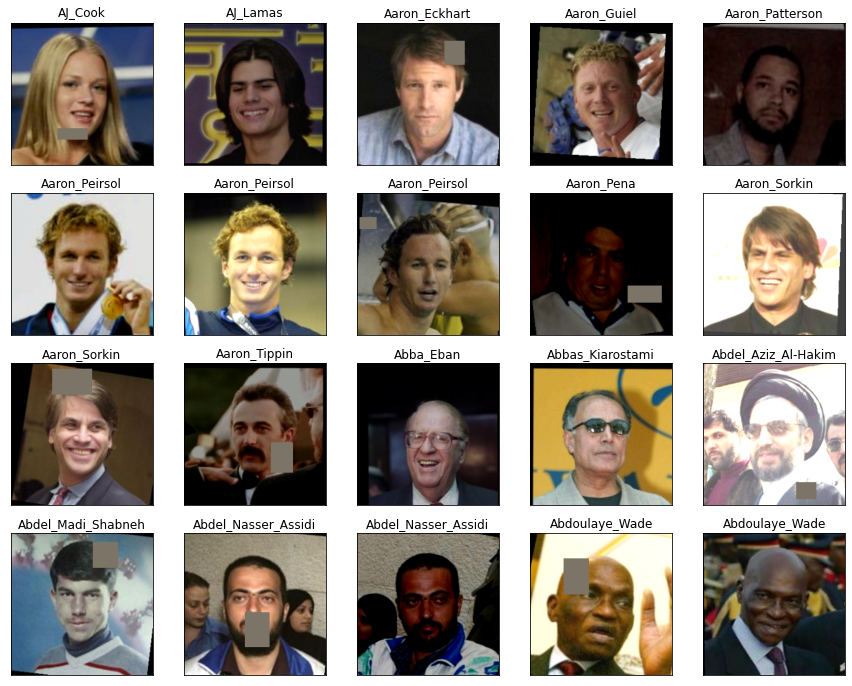

In [ ]:
# visualize how image augmentation is applied on few training dataset images: 
putils.plot_dataset_images(train_loader, figsize=(15,12), save_filename=f'{PLOT_DIR}/dataset_samples.jpg')

In [ ]:
%time
samples = next(iter(train_loader))

# Image dimension
print(f'Image size: {samples[0][0].shape}')

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs
Image size: torch.Size([3, 224, 224])


# Pretrained InceptionResnetV1 network

In [ ]:
# load pre-training model
from fr_models.inception_resnet_v1 import InceptionResnetV1
model_ft = InceptionResnetV1(pretrained='vggface2', classify=False, num_classes=num_classes)

In [ ]:
# view last few layesr to find out layesr we need to chnage and unfreeze
list(model_ft.children())[-6:]

[Block8(
   (branch0): BasicConv2d(
     (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU()
   )
   (branch1): Sequential(
     (0): BasicConv2d(
       (conv): Conv2d(1792, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (1): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(1, 3), stride=(1, 1), padding=(0, 1), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
     (2): BasicConv2d(
       (conv): Conv2d(192, 192, kernel_size=(3, 1), stride=(1, 1), padding=(1, 0), bias=False)
       (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU()
     )
   )
   (conv2d): Conv2d(384, 1792,

In [ ]:
# Remove the last layers after conv block and place in layer_list .
layer_list = list(model_ft.children())[-5:] # all final layers
layer_list

[AdaptiveAvgPool2d(output_size=1),
 Dropout(p=0.6, inplace=False),
 Linear(in_features=1792, out_features=512, bias=False),
 BatchNorm1d(512, eps=0.001, momentum=0.1, affine=True, track_running_stats=True),
 Linear(in_features=512, out_features=8631, bias=True)]

In [ ]:
# Put all beginning layers in an nn.Sequential . model_ft is now a torch model but without the final linear, pooling, batchnorm, and sigmoid layers
model_ft = nn.Sequential(*list(model_ft.children())[:-5])

# training just final layers
#for param in model_ft.parameters():
#    param.requires_grad = False

In [ ]:
from utils.lsoftmax import LSoftmaxLinear
import torch.nn as nn
import torch.nn.functional as F

class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return x
class normalize(nn.Module):
    def __init__(self):
        super(normalize, self).__init__()
        
    def forward(self, x):
        x = F.normalize(x, p=2, dim=1)
        return x

class FRConvNetwork(nn.Module):
    def __init__(self, loaded_lodel, margin, device, embedding_size, num_classes=10):
        super(FRConvNetwork, self).__init__()
        self.loaded_lodel = loaded_lodel
        self.margin = margin
        self.device = device

        self.lsoftmax_linear = LSoftmaxLinear(
            input_features=embedding_size, output_features=num_classes, margin=margin, device=device)
        
        self.reset_parameters()
    
    def reset_parameters(self):
        self.lsoftmax_linear.reset_parameters()

    def forward(self, x, target=None, embed=False):
        x = self.loaded_lodel(x)     
        if embed:
            return x   
        logit = self.lsoftmax_linear(input=x, target=target)
        return logit

In [ ]:
# apply the final layers back to the new Sequential model. these layers will be trained
embedding_size = 128
model_ft.avgpool_1a = nn.AdaptiveAvgPool2d(output_size=1)
model_ft.last_linear = nn.Sequential(
    Flatten(),
    nn.Linear(in_features=1792, out_features=512, bias=False),
    normalize()
)
model_ft.logits = nn.Linear(512, embedding_size) # Embedding vector of size 3
#model_ft.softmax = nn.Softmax(dim=1)

In [ ]:
import utils.freezeLayersUtils as freezeUtils
# unfeeze selective layer and freeze the remaining layers
unfreeze_layer_names = ['11', '12', 'last_linear', 'logits']
freezeUtils.unfreeze_layers_by_name(model_ft, unfreeze_layer_names)

In [ ]:
#freezeUtils.show_layers(model_ft)

In [ ]:
'''
from torchsummary import summary
model_name = "InceptionResnetV1_FaceRec"
model_ft = model_ft.to(device)
#summary(model_ft, input_size=(3,224,224))
print(model_ft)
'''

'\nfrom torchsummary import summary\nmodel_name = "InceptionResnetV1_FaceRec"\nmodel_ft = model_ft.to(device)\n#summary(model_ft, input_size=(3,224,224))\nprint(model_ft)\n'

In [ ]:
from torchsummary import summary
model_name = "InceptionResnetV1_FaceRec"
model = FRConvNetwork(loaded_lodel=model_ft, margin=1, device=device, embedding_size=embedding_size, num_classes=num_classes).to(device)
#summary(model, input_size=(3,224,224))
print(model)

FRConvNetwork(
  (loaded_lodel): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (relu): R

## Face Recognition Model

In [ ]:
model_name = "InceptionResnetV1_FaceRec"
model = FRConvNetwork(loaded_lodel=model_ft, margin=1, device=device,  embedding_size=embedding_size, num_classes=num_classes).to(device)

In [ ]:
import numpy as np
import torch.nn.functional as F

# fxn to get embedding vector for the samples
def get_embedding(device, model, loader, num_samples=100):
    model = model.to(device).eval()
    full_embeds = []
    full_labels = []
    with torch.no_grad():
        for i, (data, labels) in enumerate(loader):
            data = data[:num_samples].to(device) #
            full_labels.append(labels[:num_samples].cpu().detach().numpy())
            embeds = model(data, target=None, embed=True)
            full_embeds.append(F.normalize(embeds.detach().cpu()).numpy())
    model = model.cpu()
    return np.concatenate(full_embeds), np.concatenate(full_labels)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# this is to plot empbedding vector of size 3 only
def plot_embedding(embeds, labels, save_filename=None):

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')

    # Create a sphere
    r = 1
    pi = np.pi
    cos = np.cos
    sin = np.sin
    phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
    x = r*sin(phi)*cos(theta)
    y = r*sin(phi)*sin(theta)
    z = r*cos(phi)
    ax.plot_surface(
        x, y, z,  rstride=1, cstride=1, color='w', alpha=0.3, linewidth=0)
    ax.scatter(embeds[:,0], embeds[:,1], embeds[:,2], c=labels, s=20)

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([-1, 1])
    #ax.set_aspect("equal")
    plt.tight_layout()
    if save_filename:
      fig.savefig(save_filename)

## Build and train model

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau
import torch.nn.functional as F

EPOCHS = config_params['epochs']
max_lr = 0.1   # maximum LR 
min_lr = 0.015  # minimum LR 
L2_val = 1e-4 # L2 Regularization
start_epoch = 1
step_size = 12 # num of epoch, if LR is update epoch wise
if config_params["lr_update_ty"] == LR_UPDATE_TY.BATCHWISE:
  step_size = 2000

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=min_lr, momentum=0.9, nesterov=True, weight_decay=L2_val) 
#optimizer = torch.optim.Adam(model.parameters(), lr=min_lr)

# CyclicLR- use one cycle policy: MAX-LR at epoch=5, Triangular policy
lr_scheduler = CyclicLR(optimizer, base_lr=min_lr, max_lr=max_lr, step_size_up=step_size, step_size_down=step_size, mode='triangular2', last_epoch=-1)
#lr_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.1)

# reduce LR when modle get stuck in plateu region
#reduceLr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, threshold=0.001)

In [ ]:
from utils.model_utils_ext import ModelUtils
mutils = ModelUtils(model, 
                    device, 
                    train_loader=train_loader, 
                    test_loader=test_loader, 
                    start_epoch = start_epoch,
                    epochs=EPOCHS,
                    criterion=criterion, 
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    lr_update_ty=config_params['lr_update_ty'],
                    reduceLr_scheduler=None,
                    saved_model_dir=SAVED_MODELS_DIR,
                    tqdm_status=True)

In [ ]:
m_history = mutils.build()

  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 1 TRAIN ==> [Batch=46] train_loss=8.661826 train_acc: 0.10 LR=0.015000000: 100%|██████████| 46/46 [00:41<00:00,  1.10it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 1 TEST  ==> [Batch=8] test_loss=8.521224 test_acc: 8.59: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 2 TRAIN ==> [Batch=46] train_loss=8.608647 train_acc: 1.69 LR=0.022083333: 100%|██████████| 46/46 [00:42<00:00,  1.09it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 2 TEST  ==> [Batch=8] test_loss=8.353889 test_acc: 8.59: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 3 TRAIN ==> [Batch=46] train_loss=8.547098 train_acc: 3.19 LR=0.029166667: 100%|██████████| 46/46 [00:41<00:00,  1.10it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 3 TEST  ==> [Batch=8] test_loss=8.055442 test_acc: 8.59: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 4 TRAIN ==> [Batch=46] train_loss=8.528510 train_acc: 2.85 LR=0.036250000: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 4 TEST  ==> [Batch=8] test_loss=8.084849 test_acc: 12.16: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 5 TRAIN ==> [Batch=46] train_loss=8.445237 train_acc: 2.64 LR=0.043333333: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 5 TEST  ==> [Batch=8] test_loss=7.897929 test_acc: 8.75: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 6 TRAIN ==> [Batch=46] train_loss=8.384691 train_acc: 1.07 LR=0.050416667: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 6 TEST  ==> [Batch=8] test_loss=7.587882 test_acc: 8.64: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 7 TRAIN ==> [Batch=46] train_loss=8.298784 train_acc: 0.71 LR=0.057500000: 100%|██████████| 46/46 [00:42<00:00,  1.09it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 7 TEST  ==> [Batch=8] test_loss=7.506311 test_acc: 4.32: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 8 TRAIN ==> [Batch=46] train_loss=8.228163 train_acc: 1.78 LR=0.064583333: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 8 TEST  ==> [Batch=8] test_loss=7.270108 test_acc: 3.67: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 9 TRAIN ==> [Batch=46] train_loss=8.173293 train_acc: 0.11 LR=0.071666667: 100%|██████████| 46/46 [00:42<00:00,  1.09it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 9 TEST  ==> [Batch=8] test_loss=7.119586 test_acc: 6.59: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 10 TRAIN ==> [Batch=46] train_loss=8.114646 train_acc: 0.81 LR=0.078750000: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 10 TEST  ==> [Batch=8] test_loss=6.740891 test_acc: 4.81: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 11 TRAIN ==> [Batch=46] train_loss=8.023365 train_acc: 1.19 LR=0.085833333: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 11 TEST  ==> [Batch=8] test_loss=6.609149 test_acc: 5.29: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 12 TRAIN ==> [Batch=46] train_loss=7.961078 train_acc: 1.54 LR=0.092916667: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 12 TEST  ==> [Batch=8] test_loss=6.403931 test_acc: 5.83: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 13 TRAIN ==> [Batch=46] train_loss=7.880797 train_acc: 2.25 LR=0.100000000: 100%|██████████| 46/46 [00:42<00:00,  1.08it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 13 TEST  ==> [Batch=8] test_loss=6.309793 test_acc: 15.18: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 14 TRAIN ==> [Batch=46] train_loss=7.847852 train_acc: 2.58 LR=0.092916667: 100%|██████████| 46/46 [00:42<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 14 TEST  ==> [Batch=8] test_loss=6.187891 test_acc: 10.43: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 15 TRAIN ==> [Batch=46] train_loss=7.810747 train_acc: 2.09 LR=0.085833333: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 15 TEST  ==> [Batch=8] test_loss=5.937736 test_acc: 17.45: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 16 TRAIN ==> [Batch=46] train_loss=7.670755 train_acc: 2.45 LR=0.078750000: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 16 TEST  ==> [Batch=8] test_loss=5.973649 test_acc: 14.96: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 17 TRAIN ==> [Batch=46] train_loss=7.547387 train_acc: 3.46 LR=0.071666667: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 17 TEST  ==> [Batch=8] test_loss=5.743399 test_acc: 16.10: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 18 TRAIN ==> [Batch=46] train_loss=7.399841 train_acc: 5.28 LR=0.064583333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 18 TEST  ==> [Batch=8] test_loss=5.445636 test_acc: 22.47: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 19 TRAIN ==> [Batch=46] train_loss=7.250826 train_acc: 6.75 LR=0.057500000: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 19 TEST  ==> [Batch=8] test_loss=5.167096 test_acc: 26.90: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 20 TRAIN ==> [Batch=46] train_loss=7.098211 train_acc: 8.92 LR=0.050416667: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 20 TEST  ==> [Batch=8] test_loss=4.912273 test_acc: 30.74: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 21 TRAIN ==> [Batch=46] train_loss=6.991829 train_acc: 9.07 LR=0.043333333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 21 TEST  ==> [Batch=8] test_loss=4.688399 test_acc: 34.09: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 22 TRAIN ==> [Batch=46] train_loss=6.870615 train_acc: 10.80 LR=0.036250000: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 22 TEST  ==> [Batch=8] test_loss=4.551751 test_acc: 37.28: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 23 TRAIN ==> [Batch=46] train_loss=6.765090 train_acc: 12.63 LR=0.029166667: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 23 TEST  ==> [Batch=8] test_loss=4.370891 test_acc: 37.98: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 24 TRAIN ==> [Batch=46] train_loss=6.676746 train_acc: 13.89 LR=0.022083333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 24 TEST  ==> [Batch=8] test_loss=4.386261 test_acc: 38.25: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 25 TRAIN ==> [Batch=46] train_loss=6.600065 train_acc: 14.81 LR=0.015000000: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 25 TEST  ==> [Batch=8] test_loss=4.481585 test_acc: 38.30: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 26 TRAIN ==> [Batch=46] train_loss=6.531045 train_acc: 15.47 LR=0.018541667: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 26 TEST  ==> [Batch=8] test_loss=4.455836 test_acc: 37.82: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 27 TRAIN ==> [Batch=46] train_loss=6.477468 train_acc: 15.32 LR=0.022083333: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 27 TEST  ==> [Batch=8] test_loss=4.259579 test_acc: 40.19: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 28 TRAIN ==> [Batch=46] train_loss=6.410755 train_acc: 15.71 LR=0.025625000: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 28 TEST  ==> [Batch=8] test_loss=4.173529 test_acc: 38.63: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 29 TRAIN ==> [Batch=46] train_loss=6.362833 train_acc: 16.02 LR=0.029166667: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 29 TEST  ==> [Batch=8] test_loss=4.219924 test_acc: 37.44: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 30 TRAIN ==> [Batch=46] train_loss=6.273711 train_acc: 16.36 LR=0.032708333: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 30 TEST  ==> [Batch=8] test_loss=4.111737 test_acc: 39.92: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 31 TRAIN ==> [Batch=46] train_loss=6.211570 train_acc: 16.78 LR=0.036250000: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 31 TEST  ==> [Batch=8] test_loss=4.031112 test_acc: 38.79: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 32 TRAIN ==> [Batch=46] train_loss=6.162353 train_acc: 17.21 LR=0.039791667: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 32 TEST  ==> [Batch=8] test_loss=4.573451 test_acc: 34.47: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 33 TRAIN ==> [Batch=46] train_loss=6.103309 train_acc: 17.85 LR=0.043333333: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 33 TEST  ==> [Batch=8] test_loss=4.030139 test_acc: 39.01: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 34 TRAIN ==> [Batch=46] train_loss=5.979490 train_acc: 18.39 LR=0.046875000: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 34 TEST  ==> [Batch=8] test_loss=4.091266 test_acc: 38.09: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 35 TRAIN ==> [Batch=46] train_loss=5.858691 train_acc: 19.70 LR=0.050416667: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 35 TEST  ==> [Batch=8] test_loss=4.036001 test_acc: 38.68: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 36 TRAIN ==> [Batch=46] train_loss=5.875879 train_acc: 19.27 LR=0.053958333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 36 TEST  ==> [Batch=8] test_loss=3.753923 test_acc: 41.65: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 37 TRAIN ==> [Batch=46] train_loss=5.724160 train_acc: 19.92 LR=0.057500000: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 37 TEST  ==> [Batch=8] test_loss=3.925768 test_acc: 36.36: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 38 TRAIN ==> [Batch=46] train_loss=5.621552 train_acc: 20.64 LR=0.053958333: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 38 TEST  ==> [Batch=8] test_loss=4.284701 test_acc: 34.09: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 39 TRAIN ==> [Batch=46] train_loss=5.537334 train_acc: 21.71 LR=0.050416667: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 39 TEST  ==> [Batch=8] test_loss=3.953244 test_acc: 39.17: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 40 TRAIN ==> [Batch=46] train_loss=5.336561 train_acc: 23.66 LR=0.046875000: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 40 TEST  ==> [Batch=8] test_loss=3.779288 test_acc: 41.71: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 41 TRAIN ==> [Batch=46] train_loss=5.207902 train_acc: 25.08 LR=0.043333333: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 41 TEST  ==> [Batch=8] test_loss=3.590022 test_acc: 45.43: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 42 TRAIN ==> [Batch=46] train_loss=5.140857 train_acc: 25.10 LR=0.039791667: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 42 TEST  ==> [Batch=8] test_loss=3.728163 test_acc: 43.87: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 43 TRAIN ==> [Batch=46] train_loss=5.059087 train_acc: 26.01 LR=0.036250000: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 43 TEST  ==> [Batch=8] test_loss=3.618436 test_acc: 46.62: 100%|██████████| 8/8 [00:07<00:00,  1.13it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 44 TRAIN ==> [Batch=46] train_loss=4.945012 train_acc: 27.63 LR=0.032708333: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 44 TEST  ==> [Batch=8] test_loss=3.380690 test_acc: 47.11: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 45 TRAIN ==> [Batch=46] train_loss=4.913512 train_acc: 27.85 LR=0.029166667: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 45 TEST  ==> [Batch=8] test_loss=3.793250 test_acc: 42.36: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 46 TRAIN ==> [Batch=46] train_loss=4.816551 train_acc: 29.32 LR=0.025625000: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 46 TEST  ==> [Batch=8] test_loss=3.845305 test_acc: 44.68: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 47 TRAIN ==> [Batch=46] train_loss=4.756430 train_acc: 29.60 LR=0.022083333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 47 TEST  ==> [Batch=8] test_loss=3.767085 test_acc: 45.22: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 48 TRAIN ==> [Batch=46] train_loss=4.712598 train_acc: 29.93 LR=0.018541667: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 48 TEST  ==> [Batch=8] test_loss=3.952669 test_acc: 43.17: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 49 TRAIN ==> [Batch=46] train_loss=4.673339 train_acc: 30.51 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 49 TEST  ==> [Batch=8] test_loss=4.375871 test_acc: 44.62: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 50 TRAIN ==> [Batch=46] train_loss=4.602864 train_acc: 30.65 LR=0.016770833: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 50 TEST  ==> [Batch=8] test_loss=3.830641 test_acc: 50.51: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 51 TRAIN ==> [Batch=46] train_loss=4.543365 train_acc: 31.48 LR=0.018541667: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 51 TEST  ==> [Batch=8] test_loss=3.538960 test_acc: 46.84: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 52 TRAIN ==> [Batch=46] train_loss=4.487506 train_acc: 32.08 LR=0.020312500: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 52 TEST  ==> [Batch=8] test_loss=3.633568 test_acc: 48.35: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 53 TRAIN ==> [Batch=46] train_loss=4.406626 train_acc: 32.89 LR=0.022083333: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 53 TEST  ==> [Batch=8] test_loss=3.640105 test_acc: 49.70: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 54 TRAIN ==> [Batch=46] train_loss=4.362769 train_acc: 33.55 LR=0.023854167: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 54 TEST  ==> [Batch=8] test_loss=3.467741 test_acc: 47.97: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 55 TRAIN ==> [Batch=46] train_loss=4.302495 train_acc: 33.95 LR=0.025625000: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 55 TEST  ==> [Batch=8] test_loss=3.715742 test_acc: 46.79: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 56 TRAIN ==> [Batch=46] train_loss=4.250161 train_acc: 34.16 LR=0.027395833: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 56 TEST  ==> [Batch=8] test_loss=3.661232 test_acc: 48.03: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 57 TRAIN ==> [Batch=46] train_loss=4.221221 train_acc: 34.97 LR=0.029166667: 100%|██████████| 46/46 [00:44<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 57 TEST  ==> [Batch=8] test_loss=4.108630 test_acc: 45.54: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 58 TRAIN ==> [Batch=46] train_loss=4.164962 train_acc: 35.36 LR=0.030937500: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 58 TEST  ==> [Batch=8] test_loss=3.442507 test_acc: 46.41: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 59 TRAIN ==> [Batch=46] train_loss=4.086820 train_acc: 36.28 LR=0.032708333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 59 TEST  ==> [Batch=8] test_loss=3.531204 test_acc: 44.52: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 60 TRAIN ==> [Batch=46] train_loss=4.050750 train_acc: 36.88 LR=0.034479167: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 60 TEST  ==> [Batch=8] test_loss=3.366563 test_acc: 47.60: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 61 TRAIN ==> [Batch=46] train_loss=4.001454 train_acc: 37.84 LR=0.036250000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 61 TEST  ==> [Batch=8] test_loss=3.622029 test_acc: 46.68: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 62 TRAIN ==> [Batch=46] train_loss=3.946709 train_acc: 37.83 LR=0.034479167: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 62 TEST  ==> [Batch=8] test_loss=3.729079 test_acc: 45.38: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 63 TRAIN ==> [Batch=46] train_loss=3.911855 train_acc: 38.33 LR=0.032708333: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 63 TEST  ==> [Batch=8] test_loss=4.387430 test_acc: 38.03: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 64 TRAIN ==> [Batch=46] train_loss=3.812898 train_acc: 39.80 LR=0.030937500: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 64 TEST  ==> [Batch=8] test_loss=3.518401 test_acc: 45.98: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 65 TRAIN ==> [Batch=46] train_loss=3.802917 train_acc: 39.63 LR=0.029166667: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 65 TEST  ==> [Batch=8] test_loss=3.323503 test_acc: 47.81: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 66 TRAIN ==> [Batch=46] train_loss=3.728894 train_acc: 41.02 LR=0.027395833: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 66 TEST  ==> [Batch=8] test_loss=3.313728 test_acc: 49.00: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 67 TRAIN ==> [Batch=46] train_loss=3.613318 train_acc: 42.67 LR=0.025625000: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 67 TEST  ==> [Batch=8] test_loss=3.083959 test_acc: 51.86: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 68 TRAIN ==> [Batch=46] train_loss=3.630298 train_acc: 42.86 LR=0.023854167: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 68 TEST  ==> [Batch=8] test_loss=3.999393 test_acc: 45.92: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 69 TRAIN ==> [Batch=46] train_loss=3.584551 train_acc: 43.23 LR=0.022083333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 69 TEST  ==> [Batch=8] test_loss=3.117325 test_acc: 49.65: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 70 TRAIN ==> [Batch=46] train_loss=3.506310 train_acc: 43.95 LR=0.020312500: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 70 TEST  ==> [Batch=8] test_loss=2.846363 test_acc: 55.48: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 71 TRAIN ==> [Batch=46] train_loss=3.451446 train_acc: 45.15 LR=0.018541667: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 71 TEST  ==> [Batch=8] test_loss=2.824565 test_acc: 57.00: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 72 TRAIN ==> [Batch=46] train_loss=3.419401 train_acc: 45.49 LR=0.016770833: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 72 TEST  ==> [Batch=8] test_loss=2.713552 test_acc: 57.16: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 73 TRAIN ==> [Batch=46] train_loss=3.389645 train_acc: 46.01 LR=0.015000000: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 73 TEST  ==> [Batch=8] test_loss=3.008488 test_acc: 54.84: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 74 TRAIN ==> [Batch=46] train_loss=3.368072 train_acc: 46.07 LR=0.015885417: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 74 TEST  ==> [Batch=8] test_loss=2.593501 test_acc: 58.35: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 75 TRAIN ==> [Batch=46] train_loss=3.375063 train_acc: 46.71 LR=0.016770833: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 75 TEST  ==> [Batch=8] test_loss=2.754922 test_acc: 55.70: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 76 TRAIN ==> [Batch=46] train_loss=3.302964 train_acc: 47.52 LR=0.017656250: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 76 TEST  ==> [Batch=8] test_loss=2.617581 test_acc: 57.81: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 77 TRAIN ==> [Batch=46] train_loss=3.271122 train_acc: 47.65 LR=0.018541667: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 77 TEST  ==> [Batch=8] test_loss=2.568599 test_acc: 59.86: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 78 TRAIN ==> [Batch=46] train_loss=3.232926 train_acc: 48.06 LR=0.019427083: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 78 TEST  ==> [Batch=8] test_loss=2.684998 test_acc: 57.97: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 79 TRAIN ==> [Batch=46] train_loss=3.184615 train_acc: 49.04 LR=0.020312500: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 79 TEST  ==> [Batch=8] test_loss=2.399278 test_acc: 61.48: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 80 TRAIN ==> [Batch=46] train_loss=3.144038 train_acc: 49.48 LR=0.021197917: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 80 TEST  ==> [Batch=8] test_loss=2.793916 test_acc: 56.83: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 81 TRAIN ==> [Batch=46] train_loss=3.097208 train_acc: 50.39 LR=0.022083333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 81 TEST  ==> [Batch=8] test_loss=2.483939 test_acc: 62.24: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 82 TRAIN ==> [Batch=46] train_loss=3.112003 train_acc: 49.68 LR=0.022968750: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 82 TEST  ==> [Batch=8] test_loss=3.515918 test_acc: 51.86: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 83 TRAIN ==> [Batch=46] train_loss=3.082410 train_acc: 49.96 LR=0.023854167: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 83 TEST  ==> [Batch=8] test_loss=2.411834 test_acc: 62.13: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 84 TRAIN ==> [Batch=46] train_loss=3.092955 train_acc: 49.19 LR=0.024739583: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 84 TEST  ==> [Batch=8] test_loss=2.783635 test_acc: 54.84: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 85 TRAIN ==> [Batch=46] train_loss=2.995613 train_acc: 50.70 LR=0.025625000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 85 TEST  ==> [Batch=8] test_loss=2.633261 test_acc: 58.24: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 86 TRAIN ==> [Batch=46] train_loss=2.961967 train_acc: 51.10 LR=0.024739583: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 86 TEST  ==> [Batch=8] test_loss=3.444776 test_acc: 47.97: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 87 TRAIN ==> [Batch=46] train_loss=2.944064 train_acc: 51.26 LR=0.023854167: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 87 TEST  ==> [Batch=8] test_loss=3.002991 test_acc: 51.59: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 88 TRAIN ==> [Batch=46] train_loss=2.857422 train_acc: 52.48 LR=0.022968750: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 88 TEST  ==> [Batch=8] test_loss=2.948429 test_acc: 53.75: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 89 TRAIN ==> [Batch=46] train_loss=2.852049 train_acc: 52.91 LR=0.022083333: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 89 TEST  ==> [Batch=8] test_loss=3.006227 test_acc: 54.35: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 90 TRAIN ==> [Batch=46] train_loss=2.798378 train_acc: 53.75 LR=0.021197917: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 90 TEST  ==> [Batch=8] test_loss=3.014896 test_acc: 53.43: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 91 TRAIN ==> [Batch=46] train_loss=2.763104 train_acc: 54.10 LR=0.020312500: 100%|██████████| 46/46 [00:44<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 91 TEST  ==> [Batch=8] test_loss=2.876761 test_acc: 55.59: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 92 TRAIN ==> [Batch=46] train_loss=2.755401 train_acc: 54.26 LR=0.019427083: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 92 TEST  ==> [Batch=8] test_loss=2.647815 test_acc: 58.35: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 93 TRAIN ==> [Batch=46] train_loss=2.710746 train_acc: 54.82 LR=0.018541667: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 93 TEST  ==> [Batch=8] test_loss=3.370931 test_acc: 52.84: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 94 TRAIN ==> [Batch=46] train_loss=2.715650 train_acc: 54.66 LR=0.017656250: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 94 TEST  ==> [Batch=8] test_loss=2.899721 test_acc: 55.05: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 95 TRAIN ==> [Batch=46] train_loss=2.654122 train_acc: 55.65 LR=0.016770833: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 95 TEST  ==> [Batch=8] test_loss=3.312056 test_acc: 53.32: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 96 TRAIN ==> [Batch=46] train_loss=2.610538 train_acc: 55.97 LR=0.015885417: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 96 TEST  ==> [Batch=8] test_loss=2.801059 test_acc: 53.75: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 97 TRAIN ==> [Batch=46] train_loss=2.577946 train_acc: 56.70 LR=0.015000000: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 97 TEST  ==> [Batch=8] test_loss=3.211292 test_acc: 53.43: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 98 TRAIN ==> [Batch=46] train_loss=2.543630 train_acc: 57.32 LR=0.015442708: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 98 TEST  ==> [Batch=8] test_loss=2.474923 test_acc: 59.81: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 99 TRAIN ==> [Batch=46] train_loss=2.529544 train_acc: 57.04 LR=0.015885417: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 99 TEST  ==> [Batch=8] test_loss=2.849767 test_acc: 56.08: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 100 TRAIN ==> [Batch=46] train_loss=2.543415 train_acc: 57.06 LR=0.016328125: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 100 TEST  ==> [Batch=8] test_loss=2.743074 test_acc: 57.75: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 101 TRAIN ==> [Batch=46] train_loss=2.468384 train_acc: 58.47 LR=0.016770833: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 101 TEST  ==> [Batch=8] test_loss=2.623355 test_acc: 58.78: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 102 TRAIN ==> [Batch=46] train_loss=2.458768 train_acc: 58.48 LR=0.017213542: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 102 TEST  ==> [Batch=8] test_loss=2.699938 test_acc: 54.29: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 103 TRAIN ==> [Batch=46] train_loss=2.437294 train_acc: 58.76 LR=0.017656250: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 103 TEST  ==> [Batch=8] test_loss=2.555573 test_acc: 59.27: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 104 TRAIN ==> [Batch=46] train_loss=2.399443 train_acc: 59.74 LR=0.018098958: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 104 TEST  ==> [Batch=8] test_loss=2.488882 test_acc: 56.67: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 105 TRAIN ==> [Batch=46] train_loss=2.379179 train_acc: 59.60 LR=0.018541667: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 105 TEST  ==> [Batch=8] test_loss=2.682359 test_acc: 55.54: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 106 TRAIN ==> [Batch=46] train_loss=2.319494 train_acc: 61.34 LR=0.018984375: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 106 TEST  ==> [Batch=8] test_loss=2.504766 test_acc: 58.51: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 107 TRAIN ==> [Batch=46] train_loss=2.336845 train_acc: 60.55 LR=0.019427083: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 107 TEST  ==> [Batch=8] test_loss=2.630628 test_acc: 57.10: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 108 TRAIN ==> [Batch=46] train_loss=2.265074 train_acc: 61.38 LR=0.019869792: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 108 TEST  ==> [Batch=8] test_loss=2.436610 test_acc: 60.45: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 109 TRAIN ==> [Batch=46] train_loss=2.279837 train_acc: 61.98 LR=0.020312500: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 109 TEST  ==> [Batch=8] test_loss=3.051387 test_acc: 52.13: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 110 TRAIN ==> [Batch=46] train_loss=2.207509 train_acc: 62.78 LR=0.019869792: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 110 TEST  ==> [Batch=8] test_loss=2.539768 test_acc: 56.40: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 111 TRAIN ==> [Batch=46] train_loss=2.187402 train_acc: 63.47 LR=0.019427083: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 111 TEST  ==> [Batch=8] test_loss=2.411257 test_acc: 59.32: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 112 TRAIN ==> [Batch=46] train_loss=2.198552 train_acc: 63.23 LR=0.018984375: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 112 TEST  ==> [Batch=8] test_loss=2.762726 test_acc: 55.86: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 113 TRAIN ==> [Batch=46] train_loss=2.164942 train_acc: 64.14 LR=0.018541667: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 113 TEST  ==> [Batch=8] test_loss=2.614585 test_acc: 56.78: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 114 TRAIN ==> [Batch=46] train_loss=2.109858 train_acc: 65.04 LR=0.018098958: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 114 TEST  ==> [Batch=8] test_loss=2.633962 test_acc: 56.62: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 115 TRAIN ==> [Batch=46] train_loss=2.111709 train_acc: 65.03 LR=0.017656250: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 115 TEST  ==> [Batch=8] test_loss=2.493764 test_acc: 58.78: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 116 TRAIN ==> [Batch=46] train_loss=2.088068 train_acc: 65.71 LR=0.017213542: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 116 TEST  ==> [Batch=8] test_loss=2.808910 test_acc: 53.38: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 117 TRAIN ==> [Batch=46] train_loss=2.018735 train_acc: 67.26 LR=0.016770833: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 117 TEST  ==> [Batch=8] test_loss=2.608442 test_acc: 56.35: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 118 TRAIN ==> [Batch=46] train_loss=2.005895 train_acc: 67.88 LR=0.016328125: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 118 TEST  ==> [Batch=8] test_loss=2.429675 test_acc: 58.29: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 119 TRAIN ==> [Batch=46] train_loss=1.988160 train_acc: 68.60 LR=0.015885417: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 119 TEST  ==> [Batch=8] test_loss=2.420391 test_acc: 60.99: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 120 TRAIN ==> [Batch=46] train_loss=1.935649 train_acc: 69.42 LR=0.015442708: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 120 TEST  ==> [Batch=8] test_loss=2.623195 test_acc: 58.94: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 121 TRAIN ==> [Batch=46] train_loss=1.926173 train_acc: 70.05 LR=0.015000000: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 121 TEST  ==> [Batch=8] test_loss=2.451524 test_acc: 59.54: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 122 TRAIN ==> [Batch=46] train_loss=1.899763 train_acc: 70.99 LR=0.015221354: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 122 TEST  ==> [Batch=8] test_loss=2.323252 test_acc: 61.26: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 123 TRAIN ==> [Batch=46] train_loss=1.915092 train_acc: 70.36 LR=0.015442708: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 123 TEST  ==> [Batch=8] test_loss=2.465822 test_acc: 59.81: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 124 TRAIN ==> [Batch=46] train_loss=1.888442 train_acc: 71.17 LR=0.015664062: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 124 TEST  ==> [Batch=8] test_loss=2.572958 test_acc: 57.97: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 125 TRAIN ==> [Batch=46] train_loss=1.851062 train_acc: 72.39 LR=0.015885417: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 125 TEST  ==> [Batch=8] test_loss=2.426723 test_acc: 63.86: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 126 TRAIN ==> [Batch=46] train_loss=1.793600 train_acc: 73.62 LR=0.016106771: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 126 TEST  ==> [Batch=8] test_loss=2.921986 test_acc: 56.62: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 127 TRAIN ==> [Batch=46] train_loss=1.789669 train_acc: 74.10 LR=0.016328125: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 127 TEST  ==> [Batch=8] test_loss=2.478376 test_acc: 60.13: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 128 TRAIN ==> [Batch=46] train_loss=1.804732 train_acc: 73.47 LR=0.016549479: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 128 TEST  ==> [Batch=8] test_loss=2.979838 test_acc: 55.16: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 129 TRAIN ==> [Batch=46] train_loss=1.758475 train_acc: 74.61 LR=0.016770833: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 129 TEST  ==> [Batch=8] test_loss=2.430300 test_acc: 60.40: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 130 TRAIN ==> [Batch=46] train_loss=1.749389 train_acc: 74.79 LR=0.016992187: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 130 TEST  ==> [Batch=8] test_loss=2.390178 test_acc: 60.35: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 131 TRAIN ==> [Batch=46] train_loss=1.755084 train_acc: 75.20 LR=0.017213542: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 131 TEST  ==> [Batch=8] test_loss=2.658797 test_acc: 60.67: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 132 TRAIN ==> [Batch=46] train_loss=1.727531 train_acc: 75.46 LR=0.017434896: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 132 TEST  ==> [Batch=8] test_loss=2.817596 test_acc: 58.94: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 133 TRAIN ==> [Batch=46] train_loss=1.671822 train_acc: 77.85 LR=0.017656250: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 133 TEST  ==> [Batch=8] test_loss=2.397554 test_acc: 62.24: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 134 TRAIN ==> [Batch=46] train_loss=1.647930 train_acc: 78.42 LR=0.017434896: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 134 TEST  ==> [Batch=8] test_loss=2.474343 test_acc: 61.97: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 135 TRAIN ==> [Batch=46] train_loss=1.621581 train_acc: 79.14 LR=0.017213542: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 135 TEST  ==> [Batch=8] test_loss=2.670868 test_acc: 62.67: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 136 TRAIN ==> [Batch=46] train_loss=1.587992 train_acc: 79.90 LR=0.016992187: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 136 TEST  ==> [Batch=8] test_loss=2.212320 test_acc: 64.51: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 137 TRAIN ==> [Batch=46] train_loss=1.582851 train_acc: 79.95 LR=0.016770833: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 137 TEST  ==> [Batch=8] test_loss=2.441354 test_acc: 61.53: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 138 TRAIN ==> [Batch=46] train_loss=1.563833 train_acc: 81.30 LR=0.016549479: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 138 TEST  ==> [Batch=8] test_loss=2.201716 test_acc: 62.83: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 139 TRAIN ==> [Batch=46] train_loss=1.599020 train_acc: 79.70 LR=0.016328125: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 139 TEST  ==> [Batch=8] test_loss=2.610524 test_acc: 60.83: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 140 TRAIN ==> [Batch=46] train_loss=1.517855 train_acc: 82.19 LR=0.016106771: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 140 TEST  ==> [Batch=8] test_loss=2.314402 test_acc: 62.13: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 141 TRAIN ==> [Batch=46] train_loss=1.521396 train_acc: 82.16 LR=0.015885417: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 141 TEST  ==> [Batch=8] test_loss=2.718890 test_acc: 56.19: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 142 TRAIN ==> [Batch=46] train_loss=1.491846 train_acc: 82.75 LR=0.015664062: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 142 TEST  ==> [Batch=8] test_loss=2.545454 test_acc: 63.59: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 143 TRAIN ==> [Batch=46] train_loss=1.468140 train_acc: 82.90 LR=0.015442708: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 143 TEST  ==> [Batch=8] test_loss=2.959285 test_acc: 59.27: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 144 TRAIN ==> [Batch=46] train_loss=1.458858 train_acc: 83.90 LR=0.015221354: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 144 TEST  ==> [Batch=8] test_loss=2.541225 test_acc: 62.13: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 145 TRAIN ==> [Batch=46] train_loss=1.439519 train_acc: 84.62 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 145 TEST  ==> [Batch=8] test_loss=2.544256 test_acc: 62.51: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 146 TRAIN ==> [Batch=46] train_loss=1.396555 train_acc: 85.68 LR=0.015110677: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 146 TEST  ==> [Batch=8] test_loss=2.555490 test_acc: 59.75: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 147 TRAIN ==> [Batch=46] train_loss=1.413928 train_acc: 84.95 LR=0.015221354: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 147 TEST  ==> [Batch=8] test_loss=2.877497 test_acc: 59.59: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 148 TRAIN ==> [Batch=46] train_loss=1.446300 train_acc: 84.00 LR=0.015332031: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 148 TEST  ==> [Batch=8] test_loss=2.775292 test_acc: 56.40: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 149 TRAIN ==> [Batch=46] train_loss=1.381866 train_acc: 86.27 LR=0.015442708: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 149 TEST  ==> [Batch=8] test_loss=2.251873 test_acc: 62.56: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 150 TRAIN ==> [Batch=46] train_loss=1.359834 train_acc: 85.94 LR=0.015553385: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 150 TEST  ==> [Batch=8] test_loss=1.991261 test_acc: 66.02: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 151 TRAIN ==> [Batch=46] train_loss=1.382592 train_acc: 85.73 LR=0.015664062: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 151 TEST  ==> [Batch=8] test_loss=2.284598 test_acc: 63.59: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 152 TRAIN ==> [Batch=46] train_loss=1.396664 train_acc: 84.81 LR=0.015774740: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 152 TEST  ==> [Batch=8] test_loss=2.595374 test_acc: 60.18: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 153 TRAIN ==> [Batch=46] train_loss=1.325761 train_acc: 86.80 LR=0.015885417: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 153 TEST  ==> [Batch=8] test_loss=2.252856 test_acc: 62.99: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 154 TRAIN ==> [Batch=46] train_loss=1.310723 train_acc: 87.39 LR=0.015996094: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 154 TEST  ==> [Batch=8] test_loss=2.297446 test_acc: 62.13: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 155 TRAIN ==> [Batch=46] train_loss=1.309568 train_acc: 87.65 LR=0.016106771: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 155 TEST  ==> [Batch=8] test_loss=2.280327 test_acc: 63.75: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 156 TRAIN ==> [Batch=46] train_loss=1.322148 train_acc: 87.13 LR=0.016217448: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 156 TEST  ==> [Batch=8] test_loss=3.045064 test_acc: 56.35: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 157 TRAIN ==> [Batch=46] train_loss=1.284242 train_acc: 87.84 LR=0.016328125: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 157 TEST  ==> [Batch=8] test_loss=3.024380 test_acc: 57.70: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 158 TRAIN ==> [Batch=46] train_loss=1.314738 train_acc: 86.72 LR=0.016217448: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 158 TEST  ==> [Batch=8] test_loss=2.888661 test_acc: 59.81: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 159 TRAIN ==> [Batch=46] train_loss=1.286934 train_acc: 87.87 LR=0.016106771: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 159 TEST  ==> [Batch=8] test_loss=2.483890 test_acc: 61.48: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 160 TRAIN ==> [Batch=46] train_loss=1.259115 train_acc: 88.68 LR=0.015996094: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 160 TEST  ==> [Batch=8] test_loss=2.625172 test_acc: 59.37: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 161 TRAIN ==> [Batch=46] train_loss=1.260920 train_acc: 88.20 LR=0.015885417: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 161 TEST  ==> [Batch=8] test_loss=2.486849 test_acc: 64.07: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 162 TRAIN ==> [Batch=46] train_loss=1.241332 train_acc: 88.53 LR=0.015774740: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 162 TEST  ==> [Batch=8] test_loss=2.756583 test_acc: 63.37: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 163 TRAIN ==> [Batch=46] train_loss=1.217341 train_acc: 89.52 LR=0.015664062: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 163 TEST  ==> [Batch=8] test_loss=2.601567 test_acc: 61.10: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 164 TRAIN ==> [Batch=46] train_loss=1.189815 train_acc: 89.74 LR=0.015553385: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 164 TEST  ==> [Batch=8] test_loss=2.654814 test_acc: 61.48: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 165 TRAIN ==> [Batch=46] train_loss=1.183641 train_acc: 89.86 LR=0.015442708: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 165 TEST  ==> [Batch=8] test_loss=2.592511 test_acc: 57.86: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 166 TRAIN ==> [Batch=46] train_loss=1.168788 train_acc: 90.49 LR=0.015332031: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 166 TEST  ==> [Batch=8] test_loss=2.662781 test_acc: 63.37: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 167 TRAIN ==> [Batch=46] train_loss=1.177984 train_acc: 89.93 LR=0.015221354: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 167 TEST  ==> [Batch=8] test_loss=2.714181 test_acc: 58.56: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 168 TRAIN ==> [Batch=46] train_loss=1.193819 train_acc: 89.45 LR=0.015110677: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 168 TEST  ==> [Batch=8] test_loss=2.923050 test_acc: 59.59: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 169 TRAIN ==> [Batch=46] train_loss=1.135386 train_acc: 90.89 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 169 TEST  ==> [Batch=8] test_loss=2.478359 test_acc: 61.37: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 170 TRAIN ==> [Batch=46] train_loss=1.128400 train_acc: 91.03 LR=0.015055339: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 170 TEST  ==> [Batch=8] test_loss=2.875804 test_acc: 55.92: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 171 TRAIN ==> [Batch=46] train_loss=1.126532 train_acc: 90.82 LR=0.015110677: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 171 TEST  ==> [Batch=8] test_loss=2.853385 test_acc: 59.54: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 172 TRAIN ==> [Batch=46] train_loss=1.104267 train_acc: 91.39 LR=0.015166016: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 172 TEST  ==> [Batch=8] test_loss=2.643895 test_acc: 59.75: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 173 TRAIN ==> [Batch=46] train_loss=1.093140 train_acc: 91.63 LR=0.015221354: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 173 TEST  ==> [Batch=8] test_loss=2.705378 test_acc: 59.48: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 174 TRAIN ==> [Batch=46] train_loss=1.093938 train_acc: 91.46 LR=0.015276693: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 174 TEST  ==> [Batch=8] test_loss=2.489957 test_acc: 59.59: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 175 TRAIN ==> [Batch=46] train_loss=1.070247 train_acc: 91.96 LR=0.015332031: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 175 TEST  ==> [Batch=8] test_loss=2.506974 test_acc: 60.78: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 176 TRAIN ==> [Batch=46] train_loss=1.059468 train_acc: 92.06 LR=0.015387370: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 176 TEST  ==> [Batch=8] test_loss=2.361352 test_acc: 61.43: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 177 TRAIN ==> [Batch=46] train_loss=1.055057 train_acc: 91.77 LR=0.015442708: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 177 TEST  ==> [Batch=8] test_loss=2.659715 test_acc: 60.89: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 178 TRAIN ==> [Batch=46] train_loss=1.048035 train_acc: 92.14 LR=0.015498047: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 178 TEST  ==> [Batch=8] test_loss=2.568898 test_acc: 61.75: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 179 TRAIN ==> [Batch=46] train_loss=1.006842 train_acc: 93.10 LR=0.015553385: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 179 TEST  ==> [Batch=8] test_loss=2.529313 test_acc: 60.83: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 180 TRAIN ==> [Batch=46] train_loss=0.990391 train_acc: 93.05 LR=0.015608724: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 180 TEST  ==> [Batch=8] test_loss=2.407993 test_acc: 62.40: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 181 TRAIN ==> [Batch=46] train_loss=1.007080 train_acc: 92.75 LR=0.015664062: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 181 TEST  ==> [Batch=8] test_loss=2.532318 test_acc: 61.64: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 182 TRAIN ==> [Batch=46] train_loss=1.027238 train_acc: 92.41 LR=0.015608724: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 182 TEST  ==> [Batch=8] test_loss=2.937264 test_acc: 56.35: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 183 TRAIN ==> [Batch=46] train_loss=1.024524 train_acc: 91.82 LR=0.015553385: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 183 TEST  ==> [Batch=8] test_loss=2.427011 test_acc: 61.37: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 184 TRAIN ==> [Batch=46] train_loss=1.007577 train_acc: 92.45 LR=0.015498047: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 184 TEST  ==> [Batch=8] test_loss=2.754014 test_acc: 59.81: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 185 TRAIN ==> [Batch=46] train_loss=1.003285 train_acc: 92.33 LR=0.015442708: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 185 TEST  ==> [Batch=8] test_loss=3.568577 test_acc: 51.05: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 186 TRAIN ==> [Batch=46] train_loss=0.962209 train_acc: 93.57 LR=0.015387370: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 186 TEST  ==> [Batch=8] test_loss=2.883130 test_acc: 57.59: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 187 TRAIN ==> [Batch=46] train_loss=1.008167 train_acc: 91.91 LR=0.015332031: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 187 TEST  ==> [Batch=8] test_loss=2.404650 test_acc: 63.16: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 188 TRAIN ==> [Batch=46] train_loss=0.932618 train_acc: 93.84 LR=0.015276693: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 188 TEST  ==> [Batch=8] test_loss=2.627817 test_acc: 59.97: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 189 TRAIN ==> [Batch=46] train_loss=0.925895 train_acc: 93.85 LR=0.015221354: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 189 TEST  ==> [Batch=8] test_loss=2.621720 test_acc: 60.56: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 190 TRAIN ==> [Batch=46] train_loss=0.947781 train_acc: 92.98 LR=0.015166016: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 190 TEST  ==> [Batch=8] test_loss=2.656574 test_acc: 60.24: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 191 TRAIN ==> [Batch=46] train_loss=0.922882 train_acc: 93.96 LR=0.015110677: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 191 TEST  ==> [Batch=8] test_loss=2.833028 test_acc: 59.70: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 192 TRAIN ==> [Batch=46] train_loss=0.917100 train_acc: 93.43 LR=0.015055339: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 192 TEST  ==> [Batch=8] test_loss=2.822887 test_acc: 58.67: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 193 TRAIN ==> [Batch=46] train_loss=0.894217 train_acc: 94.19 LR=0.015000000: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 193 TEST  ==> [Batch=8] test_loss=2.533485 test_acc: 59.81: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 194 TRAIN ==> [Batch=46] train_loss=0.867116 train_acc: 94.50 LR=0.015027669: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 194 TEST  ==> [Batch=8] test_loss=2.850162 test_acc: 59.86: 100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 195 TRAIN ==> [Batch=46] train_loss=0.907789 train_acc: 93.66 LR=0.015055339: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 195 TEST  ==> [Batch=8] test_loss=2.609153 test_acc: 59.70: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 196 TRAIN ==> [Batch=46] train_loss=0.877238 train_acc: 94.27 LR=0.015083008: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 196 TEST  ==> [Batch=8] test_loss=3.003131 test_acc: 57.59: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 197 TRAIN ==> [Batch=46] train_loss=0.889579 train_acc: 93.77 LR=0.015110677: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 197 TEST  ==> [Batch=8] test_loss=2.281501 test_acc: 61.48: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 198 TRAIN ==> [Batch=46] train_loss=0.902732 train_acc: 93.44 LR=0.015138346: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 198 TEST  ==> [Batch=8] test_loss=2.852475 test_acc: 58.89: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 199 TRAIN ==> [Batch=46] train_loss=0.864162 train_acc: 94.58 LR=0.015166016: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 199 TEST  ==> [Batch=8] test_loss=2.582580 test_acc: 60.51: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 200 TRAIN ==> [Batch=46] train_loss=0.852447 train_acc: 94.52 LR=0.015193685: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 200 TEST  ==> [Batch=8] test_loss=2.806372 test_acc: 59.54: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 201 TRAIN ==> [Batch=46] train_loss=0.849096 train_acc: 94.39 LR=0.015221354: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 201 TEST  ==> [Batch=8] test_loss=2.390745 test_acc: 61.43: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 202 TRAIN ==> [Batch=46] train_loss=0.841525 train_acc: 94.56 LR=0.015249023: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 202 TEST  ==> [Batch=8] test_loss=2.469139 test_acc: 62.02: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 203 TRAIN ==> [Batch=46] train_loss=0.843245 train_acc: 94.23 LR=0.015276693: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 203 TEST  ==> [Batch=8] test_loss=2.439990 test_acc: 60.67: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 204 TRAIN ==> [Batch=46] train_loss=0.823655 train_acc: 94.69 LR=0.015304362: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 204 TEST  ==> [Batch=8] test_loss=2.557495 test_acc: 59.86: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 205 TRAIN ==> [Batch=46] train_loss=0.795974 train_acc: 95.11 LR=0.015332031: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 205 TEST  ==> [Batch=8] test_loss=2.644206 test_acc: 60.08: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 206 TRAIN ==> [Batch=46] train_loss=0.794197 train_acc: 95.04 LR=0.015304362: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 206 TEST  ==> [Batch=8] test_loss=2.359226 test_acc: 60.18: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 207 TRAIN ==> [Batch=46] train_loss=0.781124 train_acc: 95.38 LR=0.015276693: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 207 TEST  ==> [Batch=8] test_loss=2.401636 test_acc: 60.89: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 208 TRAIN ==> [Batch=46] train_loss=0.790495 train_acc: 95.13 LR=0.015249023: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 208 TEST  ==> [Batch=8] test_loss=2.833190 test_acc: 58.18: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 209 TRAIN ==> [Batch=46] train_loss=0.789843 train_acc: 94.87 LR=0.015221354: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 209 TEST  ==> [Batch=8] test_loss=3.371271 test_acc: 52.57: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 210 TRAIN ==> [Batch=46] train_loss=0.761695 train_acc: 95.30 LR=0.015193685: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 210 TEST  ==> [Batch=8] test_loss=2.419600 test_acc: 61.16: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 211 TRAIN ==> [Batch=46] train_loss=0.760030 train_acc: 95.64 LR=0.015166016: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 211 TEST  ==> [Batch=8] test_loss=2.948893 test_acc: 56.19: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 212 TRAIN ==> [Batch=46] train_loss=0.768069 train_acc: 94.94 LR=0.015138346: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 212 TEST  ==> [Batch=8] test_loss=2.758740 test_acc: 56.56: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 213 TRAIN ==> [Batch=46] train_loss=0.751163 train_acc: 95.36 LR=0.015110677: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 213 TEST  ==> [Batch=8] test_loss=3.019142 test_acc: 56.46: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 214 TRAIN ==> [Batch=46] train_loss=0.734101 train_acc: 95.86 LR=0.015083008: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 214 TEST  ==> [Batch=8] test_loss=2.663568 test_acc: 58.40: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 215 TRAIN ==> [Batch=46] train_loss=0.737868 train_acc: 95.52 LR=0.015055339: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 215 TEST  ==> [Batch=8] test_loss=2.529916 test_acc: 60.94: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 216 TRAIN ==> [Batch=46] train_loss=0.714045 train_acc: 95.89 LR=0.015027669: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 216 TEST  ==> [Batch=8] test_loss=2.374555 test_acc: 62.56: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 217 TRAIN ==> [Batch=46] train_loss=0.737689 train_acc: 95.34 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 217 TEST  ==> [Batch=8] test_loss=2.447235 test_acc: 60.99: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 218 TRAIN ==> [Batch=46] train_loss=0.713317 train_acc: 95.68 LR=0.015013835: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 218 TEST  ==> [Batch=8] test_loss=2.504888 test_acc: 62.67: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 219 TRAIN ==> [Batch=46] train_loss=0.692990 train_acc: 96.04 LR=0.015027669: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 219 TEST  ==> [Batch=8] test_loss=2.334528 test_acc: 61.80: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 220 TRAIN ==> [Batch=46] train_loss=0.698527 train_acc: 96.01 LR=0.015041504: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 220 TEST  ==> [Batch=8] test_loss=3.160233 test_acc: 57.00: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 221 TRAIN ==> [Batch=46] train_loss=0.679032 train_acc: 96.23 LR=0.015055339: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 221 TEST  ==> [Batch=8] test_loss=2.897074 test_acc: 59.59: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 222 TRAIN ==> [Batch=46] train_loss=0.691796 train_acc: 95.97 LR=0.015069173: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 222 TEST  ==> [Batch=8] test_loss=3.241071 test_acc: 55.48: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 223 TRAIN ==> [Batch=46] train_loss=0.689810 train_acc: 95.93 LR=0.015083008: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 223 TEST  ==> [Batch=8] test_loss=2.674000 test_acc: 59.43: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 224 TRAIN ==> [Batch=46] train_loss=0.688172 train_acc: 95.65 LR=0.015096842: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 224 TEST  ==> [Batch=8] test_loss=2.692995 test_acc: 59.64: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 225 TRAIN ==> [Batch=46] train_loss=0.704250 train_acc: 95.26 LR=0.015110677: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 225 TEST  ==> [Batch=8] test_loss=2.832333 test_acc: 59.21: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 226 TRAIN ==> [Batch=46] train_loss=0.678358 train_acc: 95.96 LR=0.015124512: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 226 TEST  ==> [Batch=8] test_loss=2.656156 test_acc: 59.32: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 227 TRAIN ==> [Batch=46] train_loss=0.675844 train_acc: 95.67 LR=0.015138346: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 227 TEST  ==> [Batch=8] test_loss=2.471405 test_acc: 61.05: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 228 TRAIN ==> [Batch=46] train_loss=0.665100 train_acc: 96.05 LR=0.015152181: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 228 TEST  ==> [Batch=8] test_loss=2.499922 test_acc: 59.48: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 229 TRAIN ==> [Batch=46] train_loss=0.674565 train_acc: 95.72 LR=0.015166016: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 229 TEST  ==> [Batch=8] test_loss=2.550633 test_acc: 59.64: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 230 TRAIN ==> [Batch=46] train_loss=0.640793 train_acc: 96.40 LR=0.015152181: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 230 TEST  ==> [Batch=8] test_loss=2.618879 test_acc: 59.27: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 231 TRAIN ==> [Batch=46] train_loss=0.636542 train_acc: 96.50 LR=0.015138346: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 231 TEST  ==> [Batch=8] test_loss=2.518994 test_acc: 61.48: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 232 TRAIN ==> [Batch=46] train_loss=0.630767 train_acc: 96.35 LR=0.015124512: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 232 TEST  ==> [Batch=8] test_loss=2.340673 test_acc: 62.40: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 233 TRAIN ==> [Batch=46] train_loss=0.612909 train_acc: 96.72 LR=0.015110677: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 233 TEST  ==> [Batch=8] test_loss=2.726580 test_acc: 62.29: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 234 TRAIN ==> [Batch=46] train_loss=0.615165 train_acc: 96.44 LR=0.015096842: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 234 TEST  ==> [Batch=8] test_loss=2.874542 test_acc: 59.54: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 235 TRAIN ==> [Batch=46] train_loss=0.605555 train_acc: 96.42 LR=0.015083008: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 235 TEST  ==> [Batch=8] test_loss=2.581570 test_acc: 61.70: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 236 TRAIN ==> [Batch=46] train_loss=0.648089 train_acc: 95.60 LR=0.015069173: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 236 TEST  ==> [Batch=8] test_loss=2.879785 test_acc: 57.48: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 237 TRAIN ==> [Batch=46] train_loss=0.603165 train_acc: 96.64 LR=0.015055339: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 237 TEST  ==> [Batch=8] test_loss=2.523403 test_acc: 60.24: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 238 TRAIN ==> [Batch=46] train_loss=0.626070 train_acc: 96.04 LR=0.015041504: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 238 TEST  ==> [Batch=8] test_loss=2.385000 test_acc: 62.94: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 239 TRAIN ==> [Batch=46] train_loss=0.614545 train_acc: 96.22 LR=0.015027669: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 239 TEST  ==> [Batch=8] test_loss=2.446150 test_acc: 61.97: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 240 TRAIN ==> [Batch=46] train_loss=0.587146 train_acc: 96.87 LR=0.015013835: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 240 TEST  ==> [Batch=8] test_loss=2.319996 test_acc: 61.75: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 241 TRAIN ==> [Batch=46] train_loss=0.591656 train_acc: 96.53 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 241 TEST  ==> [Batch=8] test_loss=2.324550 test_acc: 63.10: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 242 TRAIN ==> [Batch=46] train_loss=0.593669 train_acc: 96.38 LR=0.015006917: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 242 TEST  ==> [Batch=8] test_loss=2.643859 test_acc: 58.73: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 243 TRAIN ==> [Batch=46] train_loss=0.596014 train_acc: 96.46 LR=0.015013835: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 243 TEST  ==> [Batch=8] test_loss=2.895618 test_acc: 55.05: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 244 TRAIN ==> [Batch=46] train_loss=0.590151 train_acc: 96.39 LR=0.015020752: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 244 TEST  ==> [Batch=8] test_loss=2.312336 test_acc: 60.83: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 245 TRAIN ==> [Batch=46] train_loss=0.563370 train_acc: 96.91 LR=0.015027669: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 245 TEST  ==> [Batch=8] test_loss=2.363875 test_acc: 60.13: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 246 TRAIN ==> [Batch=46] train_loss=0.575610 train_acc: 96.66 LR=0.015034587: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 246 TEST  ==> [Batch=8] test_loss=2.833041 test_acc: 55.97: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 247 TRAIN ==> [Batch=46] train_loss=0.598298 train_acc: 95.98 LR=0.015041504: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 247 TEST  ==> [Batch=8] test_loss=2.996878 test_acc: 57.27: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 248 TRAIN ==> [Batch=46] train_loss=0.562480 train_acc: 96.69 LR=0.015048421: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 248 TEST  ==> [Batch=8] test_loss=2.560170 test_acc: 59.81: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 249 TRAIN ==> [Batch=46] train_loss=0.568789 train_acc: 96.36 LR=0.015055339: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 249 TEST  ==> [Batch=8] test_loss=2.784161 test_acc: 56.94: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 250 TRAIN ==> [Batch=46] train_loss=0.556495 train_acc: 96.74 LR=0.015062256: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 250 TEST  ==> [Batch=8] test_loss=2.770361 test_acc: 59.00: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 251 TRAIN ==> [Batch=46] train_loss=0.554617 train_acc: 96.57 LR=0.015069173: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 251 TEST  ==> [Batch=8] test_loss=2.962463 test_acc: 57.75: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 252 TRAIN ==> [Batch=46] train_loss=0.552169 train_acc: 96.81 LR=0.015076090: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 252 TEST  ==> [Batch=8] test_loss=3.421154 test_acc: 52.40: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 253 TRAIN ==> [Batch=46] train_loss=0.570297 train_acc: 96.27 LR=0.015083008: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 253 TEST  ==> [Batch=8] test_loss=2.987025 test_acc: 59.86: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 254 TRAIN ==> [Batch=46] train_loss=0.542577 train_acc: 97.00 LR=0.015076090: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 254 TEST  ==> [Batch=8] test_loss=2.772235 test_acc: 61.70: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 255 TRAIN ==> [Batch=46] train_loss=0.535165 train_acc: 96.72 LR=0.015069173: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 255 TEST  ==> [Batch=8] test_loss=2.773033 test_acc: 61.86: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 256 TRAIN ==> [Batch=46] train_loss=0.542840 train_acc: 96.72 LR=0.015062256: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 256 TEST  ==> [Batch=8] test_loss=2.915146 test_acc: 58.83: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 257 TRAIN ==> [Batch=46] train_loss=0.522854 train_acc: 97.04 LR=0.015055339: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 257 TEST  ==> [Batch=8] test_loss=2.417669 test_acc: 61.86: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 258 TRAIN ==> [Batch=46] train_loss=0.542107 train_acc: 96.54 LR=0.015048421: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 258 TEST  ==> [Batch=8] test_loss=2.853640 test_acc: 54.78: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 259 TRAIN ==> [Batch=46] train_loss=0.553987 train_acc: 96.02 LR=0.015041504: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 259 TEST  ==> [Batch=8] test_loss=2.719994 test_acc: 58.51: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 260 TRAIN ==> [Batch=46] train_loss=0.525843 train_acc: 96.87 LR=0.015034587: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 260 TEST  ==> [Batch=8] test_loss=2.585666 test_acc: 62.51: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 261 TRAIN ==> [Batch=46] train_loss=0.531560 train_acc: 96.59 LR=0.015027669: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 261 TEST  ==> [Batch=8] test_loss=2.722363 test_acc: 58.35: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 262 TRAIN ==> [Batch=46] train_loss=0.530508 train_acc: 96.52 LR=0.015020752: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 262 TEST  ==> [Batch=8] test_loss=2.884079 test_acc: 58.89: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 263 TRAIN ==> [Batch=46] train_loss=0.503937 train_acc: 96.90 LR=0.015013835: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 263 TEST  ==> [Batch=8] test_loss=2.772740 test_acc: 61.80: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 264 TRAIN ==> [Batch=46] train_loss=0.511842 train_acc: 96.67 LR=0.015006917: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 264 TEST  ==> [Batch=8] test_loss=2.638132 test_acc: 62.67: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 265 TRAIN ==> [Batch=46] train_loss=0.502565 train_acc: 97.02 LR=0.015000000: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 265 TEST  ==> [Batch=8] test_loss=2.589726 test_acc: 60.24: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 266 TRAIN ==> [Batch=46] train_loss=0.489672 train_acc: 97.27 LR=0.015003459: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 266 TEST  ==> [Batch=8] test_loss=2.979252 test_acc: 58.13: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 267 TRAIN ==> [Batch=46] train_loss=0.481105 train_acc: 97.39 LR=0.015006917: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 267 TEST  ==> [Batch=8] test_loss=3.269580 test_acc: 58.35: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 268 TRAIN ==> [Batch=46] train_loss=0.477751 train_acc: 97.25 LR=0.015010376: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 268 TEST  ==> [Batch=8] test_loss=3.024162 test_acc: 57.86: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 269 TRAIN ==> [Batch=46] train_loss=0.479117 train_acc: 97.33 LR=0.015013835: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 269 TEST  ==> [Batch=8] test_loss=2.721105 test_acc: 56.89: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 270 TRAIN ==> [Batch=46] train_loss=0.487648 train_acc: 97.15 LR=0.015017293: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 270 TEST  ==> [Batch=8] test_loss=2.621771 test_acc: 60.18: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 271 TRAIN ==> [Batch=46] train_loss=0.477716 train_acc: 97.08 LR=0.015020752: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 271 TEST  ==> [Batch=8] test_loss=3.256174 test_acc: 55.81: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 272 TRAIN ==> [Batch=46] train_loss=0.479020 train_acc: 96.99 LR=0.015024211: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 272 TEST  ==> [Batch=8] test_loss=2.653662 test_acc: 58.45: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 273 TRAIN ==> [Batch=46] train_loss=0.472770 train_acc: 97.29 LR=0.015027669: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 273 TEST  ==> [Batch=8] test_loss=2.752029 test_acc: 59.43: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 274 TRAIN ==> [Batch=46] train_loss=0.479487 train_acc: 96.79 LR=0.015031128: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 274 TEST  ==> [Batch=8] test_loss=2.541180 test_acc: 60.02: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 275 TRAIN ==> [Batch=46] train_loss=0.484782 train_acc: 96.89 LR=0.015034587: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 275 TEST  ==> [Batch=8] test_loss=2.673092 test_acc: 60.02: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 276 TRAIN ==> [Batch=46] train_loss=0.460640 train_acc: 97.37 LR=0.015038045: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 276 TEST  ==> [Batch=8] test_loss=3.377793 test_acc: 56.94: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 277 TRAIN ==> [Batch=46] train_loss=0.462571 train_acc: 96.90 LR=0.015041504: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 277 TEST  ==> [Batch=8] test_loss=2.916107 test_acc: 58.24: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 278 TRAIN ==> [Batch=46] train_loss=0.451740 train_acc: 97.51 LR=0.015038045: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 278 TEST  ==> [Batch=8] test_loss=2.413937 test_acc: 60.78: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 279 TRAIN ==> [Batch=46] train_loss=0.437598 train_acc: 97.33 LR=0.015034587: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 279 TEST  ==> [Batch=8] test_loss=2.780822 test_acc: 58.89: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 280 TRAIN ==> [Batch=46] train_loss=0.453131 train_acc: 97.58 LR=0.015031128: 100%|██████████| 46/46 [00:42<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 280 TEST  ==> [Batch=8] test_loss=2.625288 test_acc: 57.70: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 281 TRAIN ==> [Batch=46] train_loss=0.446555 train_acc: 97.25 LR=0.015027669: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 281 TEST  ==> [Batch=8] test_loss=2.500580 test_acc: 59.81: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 282 TRAIN ==> [Batch=46] train_loss=0.470133 train_acc: 96.80 LR=0.015024211: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 282 TEST  ==> [Batch=8] test_loss=2.653283 test_acc: 58.62: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 283 TRAIN ==> [Batch=46] train_loss=0.453167 train_acc: 97.10 LR=0.015020752: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 283 TEST  ==> [Batch=8] test_loss=2.545068 test_acc: 61.80: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 284 TRAIN ==> [Batch=46] train_loss=0.458741 train_acc: 97.12 LR=0.015017293: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 284 TEST  ==> [Batch=8] test_loss=3.132851 test_acc: 54.29: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 285 TRAIN ==> [Batch=46] train_loss=0.449269 train_acc: 97.22 LR=0.015013835: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 285 TEST  ==> [Batch=8] test_loss=3.063035 test_acc: 57.05: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 286 TRAIN ==> [Batch=46] train_loss=0.456956 train_acc: 97.07 LR=0.015010376: 100%|██████████| 46/46 [00:42<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 286 TEST  ==> [Batch=8] test_loss=2.443424 test_acc: 60.51: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 287 TRAIN ==> [Batch=46] train_loss=0.434136 train_acc: 97.37 LR=0.015006917: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 287 TEST  ==> [Batch=8] test_loss=2.819104 test_acc: 58.89: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 288 TRAIN ==> [Batch=46] train_loss=0.440294 train_acc: 97.22 LR=0.015003459: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 288 TEST  ==> [Batch=8] test_loss=2.845401 test_acc: 58.02: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 289 TRAIN ==> [Batch=46] train_loss=0.416217 train_acc: 97.67 LR=0.015000000: 100%|██████████| 46/46 [00:42<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 289 TEST  ==> [Batch=8] test_loss=2.989584 test_acc: 58.94: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 290 TRAIN ==> [Batch=46] train_loss=0.414824 train_acc: 97.65 LR=0.015001729: 100%|██████████| 46/46 [00:43<00:00,  1.07it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 290 TEST  ==> [Batch=8] test_loss=2.806530 test_acc: 57.75: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 291 TRAIN ==> [Batch=46] train_loss=0.410901 train_acc: 97.86 LR=0.015003459: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 291 TEST  ==> [Batch=8] test_loss=2.638690 test_acc: 61.16: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 292 TRAIN ==> [Batch=46] train_loss=0.408589 train_acc: 97.76 LR=0.015005188: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 292 TEST  ==> [Batch=8] test_loss=2.469414 test_acc: 61.86: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 293 TRAIN ==> [Batch=46] train_loss=0.428378 train_acc: 97.43 LR=0.015006917: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 293 TEST  ==> [Batch=8] test_loss=2.768151 test_acc: 59.48: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 294 TRAIN ==> [Batch=46] train_loss=0.402167 train_acc: 97.71 LR=0.015008647: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 294 TEST  ==> [Batch=8] test_loss=2.842879 test_acc: 58.02: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 295 TRAIN ==> [Batch=46] train_loss=0.406002 train_acc: 97.89 LR=0.015010376: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 295 TEST  ==> [Batch=8] test_loss=2.701859 test_acc: 60.24: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 296 TRAIN ==> [Batch=46] train_loss=0.405446 train_acc: 97.61 LR=0.015012105: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 296 TEST  ==> [Batch=8] test_loss=2.578714 test_acc: 59.75: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 297 TRAIN ==> [Batch=46] train_loss=0.404939 train_acc: 97.61 LR=0.015013835: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 297 TEST  ==> [Batch=8] test_loss=2.789839 test_acc: 57.64: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 298 TRAIN ==> [Batch=46] train_loss=0.410242 train_acc: 97.53 LR=0.015015564: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 298 TEST  ==> [Batch=8] test_loss=2.562497 test_acc: 57.43: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 299 TRAIN ==> [Batch=46] train_loss=0.414914 train_acc: 97.44 LR=0.015017293: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 299 TEST  ==> [Batch=8] test_loss=2.790199 test_acc: 56.24: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 300 TRAIN ==> [Batch=46] train_loss=0.414086 train_acc: 97.43 LR=0.015019023: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 300 TEST  ==> [Batch=8] test_loss=2.838565 test_acc: 59.10: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 301 TRAIN ==> [Batch=46] train_loss=0.407655 train_acc: 97.34 LR=0.015020752: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 301 TEST  ==> [Batch=8] test_loss=2.656904 test_acc: 60.78: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 302 TRAIN ==> [Batch=46] train_loss=0.384065 train_acc: 97.88 LR=0.015019023: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 302 TEST  ==> [Batch=8] test_loss=2.310795 test_acc: 62.88: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 303 TRAIN ==> [Batch=46] train_loss=0.387393 train_acc: 97.85 LR=0.015017293: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 303 TEST  ==> [Batch=8] test_loss=2.678686 test_acc: 61.26: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 304 TRAIN ==> [Batch=46] train_loss=0.405546 train_acc: 97.40 LR=0.015015564: 100%|██████████| 46/46 [00:43<00:00,  1.06it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 304 TEST  ==> [Batch=8] test_loss=2.664587 test_acc: 57.75: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 305 TRAIN ==> [Batch=46] train_loss=0.385020 train_acc: 97.77 LR=0.015013835: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 305 TEST  ==> [Batch=8] test_loss=2.727748 test_acc: 58.35: 100%|██████████| 8/8 [00:07<00:00,  1.12it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 306 TRAIN ==> [Batch=46] train_loss=0.387335 train_acc: 97.58 LR=0.015012105: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 306 TEST  ==> [Batch=8] test_loss=2.674895 test_acc: 59.64: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 307 TRAIN ==> [Batch=46] train_loss=0.398060 train_acc: 97.52 LR=0.015010376: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 307 TEST  ==> [Batch=8] test_loss=2.859741 test_acc: 57.32: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 308 TRAIN ==> [Batch=46] train_loss=0.410308 train_acc: 97.33 LR=0.015008647: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 308 TEST  ==> [Batch=8] test_loss=2.944305 test_acc: 57.10: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 309 TRAIN ==> [Batch=46] train_loss=0.387885 train_acc: 97.69 LR=0.015006917: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 309 TEST  ==> [Batch=8] test_loss=2.865479 test_acc: 58.35: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 310 TRAIN ==> [Batch=46] train_loss=0.411455 train_acc: 97.09 LR=0.015005188: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 310 TEST  ==> [Batch=8] test_loss=3.340397 test_acc: 52.35: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 311 TRAIN ==> [Batch=46] train_loss=0.388280 train_acc: 97.46 LR=0.015003459: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 311 TEST  ==> [Batch=8] test_loss=3.080646 test_acc: 57.64: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 312 TRAIN ==> [Batch=46] train_loss=0.368518 train_acc: 97.82 LR=0.015001729: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 312 TEST  ==> [Batch=8] test_loss=2.927534 test_acc: 58.78: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 313 TRAIN ==> [Batch=46] train_loss=0.397185 train_acc: 97.43 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 313 TEST  ==> [Batch=8] test_loss=3.279196 test_acc: 55.86: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 314 TRAIN ==> [Batch=46] train_loss=0.371561 train_acc: 97.82 LR=0.015000865: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 314 TEST  ==> [Batch=8] test_loss=3.122511 test_acc: 57.81: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 315 TRAIN ==> [Batch=46] train_loss=0.368992 train_acc: 97.84 LR=0.015001729: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 315 TEST  ==> [Batch=8] test_loss=3.420055 test_acc: 56.62: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 316 TRAIN ==> [Batch=46] train_loss=0.397496 train_acc: 97.39 LR=0.015002594: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 316 TEST  ==> [Batch=8] test_loss=2.911780 test_acc: 59.16: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 317 TRAIN ==> [Batch=46] train_loss=0.404853 train_acc: 97.21 LR=0.015003459: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 317 TEST  ==> [Batch=8] test_loss=2.835342 test_acc: 57.59: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 318 TRAIN ==> [Batch=46] train_loss=0.398719 train_acc: 96.99 LR=0.015004323: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 318 TEST  ==> [Batch=8] test_loss=3.463519 test_acc: 53.54: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 319 TRAIN ==> [Batch=46] train_loss=0.390116 train_acc: 97.29 LR=0.015005188: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 319 TEST  ==> [Batch=8] test_loss=2.806931 test_acc: 56.89: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 320 TRAIN ==> [Batch=46] train_loss=0.392558 train_acc: 97.33 LR=0.015006053: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 320 TEST  ==> [Batch=8] test_loss=2.881322 test_acc: 56.83: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 321 TRAIN ==> [Batch=46] train_loss=0.370375 train_acc: 97.70 LR=0.015006917: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 321 TEST  ==> [Batch=8] test_loss=2.943876 test_acc: 59.27: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 322 TRAIN ==> [Batch=46] train_loss=0.354617 train_acc: 97.81 LR=0.015007782: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 322 TEST  ==> [Batch=8] test_loss=2.819019 test_acc: 59.16: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 323 TRAIN ==> [Batch=46] train_loss=0.377176 train_acc: 97.40 LR=0.015008647: 100%|██████████| 46/46 [00:43<00:00,  1.05it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 323 TEST  ==> [Batch=8] test_loss=2.873716 test_acc: 56.40: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 324 TRAIN ==> [Batch=46] train_loss=0.350798 train_acc: 97.89 LR=0.015009511: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 324 TEST  ==> [Batch=8] test_loss=2.623270 test_acc: 59.43: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 325 TRAIN ==> [Batch=46] train_loss=0.339613 train_acc: 98.07 LR=0.015010376: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 325 TEST  ==> [Batch=8] test_loss=2.340959 test_acc: 61.97: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 326 TRAIN ==> [Batch=46] train_loss=0.351370 train_acc: 97.93 LR=0.015009511: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 326 TEST  ==> [Batch=8] test_loss=2.626810 test_acc: 60.56: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 327 TRAIN ==> [Batch=46] train_loss=0.340244 train_acc: 97.93 LR=0.015008647: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 327 TEST  ==> [Batch=8] test_loss=2.715365 test_acc: 59.10: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 328 TRAIN ==> [Batch=46] train_loss=0.346975 train_acc: 97.90 LR=0.015007782: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 328 TEST  ==> [Batch=8] test_loss=2.839769 test_acc: 56.29: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 329 TRAIN ==> [Batch=46] train_loss=0.344486 train_acc: 98.06 LR=0.015006917: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 329 TEST  ==> [Batch=8] test_loss=2.305700 test_acc: 62.24: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 330 TRAIN ==> [Batch=46] train_loss=0.358700 train_acc: 97.58 LR=0.015006053: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 330 TEST  ==> [Batch=8] test_loss=2.456598 test_acc: 61.16: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 331 TRAIN ==> [Batch=46] train_loss=0.346738 train_acc: 97.89 LR=0.015005188: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 331 TEST  ==> [Batch=8] test_loss=2.423970 test_acc: 58.62: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 332 TRAIN ==> [Batch=46] train_loss=0.322650 train_acc: 98.13 LR=0.015004323: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 332 TEST  ==> [Batch=8] test_loss=2.372398 test_acc: 60.45: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 333 TRAIN ==> [Batch=46] train_loss=0.323351 train_acc: 98.20 LR=0.015003459: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 333 TEST  ==> [Batch=8] test_loss=2.289430 test_acc: 60.40: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 334 TRAIN ==> [Batch=46] train_loss=0.354494 train_acc: 97.63 LR=0.015002594: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 334 TEST  ==> [Batch=8] test_loss=2.762687 test_acc: 56.02: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 335 TRAIN ==> [Batch=46] train_loss=0.348469 train_acc: 97.76 LR=0.015001729: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 335 TEST  ==> [Batch=8] test_loss=2.353094 test_acc: 60.45: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 336 TRAIN ==> [Batch=46] train_loss=0.339652 train_acc: 97.74 LR=0.015000865: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 336 TEST  ==> [Batch=8] test_loss=2.149943 test_acc: 62.67: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 337 TRAIN ==> [Batch=46] train_loss=0.337070 train_acc: 97.93 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 337 TEST  ==> [Batch=8] test_loss=2.512832 test_acc: 58.89: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 338 TRAIN ==> [Batch=46] train_loss=0.337283 train_acc: 97.95 LR=0.015000432: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 338 TEST  ==> [Batch=8] test_loss=2.639621 test_acc: 59.43: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 339 TRAIN ==> [Batch=46] train_loss=0.318661 train_acc: 98.08 LR=0.015000865: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 339 TEST  ==> [Batch=8] test_loss=2.730935 test_acc: 58.24: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 340 TRAIN ==> [Batch=46] train_loss=0.325678 train_acc: 98.07 LR=0.015001297: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 340 TEST  ==> [Batch=8] test_loss=2.945795 test_acc: 56.19: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 341 TRAIN ==> [Batch=46] train_loss=0.314559 train_acc: 98.23 LR=0.015001729: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 341 TEST  ==> [Batch=8] test_loss=2.513430 test_acc: 60.51: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 342 TRAIN ==> [Batch=46] train_loss=0.343642 train_acc: 97.77 LR=0.015002162: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 342 TEST  ==> [Batch=8] test_loss=2.639125 test_acc: 57.48: 100%|██████████| 8/8 [00:07<00:00,  1.02it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 343 TRAIN ==> [Batch=46] train_loss=0.339285 train_acc: 97.76 LR=0.015002594: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 343 TEST  ==> [Batch=8] test_loss=2.871261 test_acc: 54.67: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 344 TRAIN ==> [Batch=46] train_loss=0.323384 train_acc: 98.07 LR=0.015003026: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 344 TEST  ==> [Batch=8] test_loss=2.646739 test_acc: 59.27: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 345 TRAIN ==> [Batch=46] train_loss=0.314903 train_acc: 98.07 LR=0.015003459: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 345 TEST  ==> [Batch=8] test_loss=2.622007 test_acc: 60.78: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 346 TRAIN ==> [Batch=46] train_loss=0.310724 train_acc: 98.25 LR=0.015003891: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 346 TEST  ==> [Batch=8] test_loss=3.456229 test_acc: 50.35: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 347 TRAIN ==> [Batch=46] train_loss=0.327333 train_acc: 97.91 LR=0.015004323: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 347 TEST  ==> [Batch=8] test_loss=3.389213 test_acc: 49.32: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 348 TRAIN ==> [Batch=46] train_loss=0.328903 train_acc: 97.88 LR=0.015004756: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 348 TEST  ==> [Batch=8] test_loss=3.166803 test_acc: 59.32: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 349 TRAIN ==> [Batch=46] train_loss=0.317388 train_acc: 97.95 LR=0.015005188: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 349 TEST  ==> [Batch=8] test_loss=3.140783 test_acc: 53.11: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 350 TRAIN ==> [Batch=46] train_loss=0.315658 train_acc: 98.00 LR=0.015004756: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 350 TEST  ==> [Batch=8] test_loss=2.504173 test_acc: 61.32: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 351 TRAIN ==> [Batch=46] train_loss=0.307239 train_acc: 98.23 LR=0.015004323: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 351 TEST  ==> [Batch=8] test_loss=2.721970 test_acc: 57.86: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 352 TRAIN ==> [Batch=46] train_loss=0.323086 train_acc: 97.95 LR=0.015003891: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 352 TEST  ==> [Batch=8] test_loss=3.039133 test_acc: 57.54: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 353 TRAIN ==> [Batch=46] train_loss=0.337460 train_acc: 97.74 LR=0.015003459: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 353 TEST  ==> [Batch=8] test_loss=2.796239 test_acc: 58.18: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 354 TRAIN ==> [Batch=46] train_loss=0.307496 train_acc: 98.13 LR=0.015003026: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 354 TEST  ==> [Batch=8] test_loss=2.540079 test_acc: 60.08: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 355 TRAIN ==> [Batch=46] train_loss=0.306869 train_acc: 98.10 LR=0.015002594: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 355 TEST  ==> [Batch=8] test_loss=2.471818 test_acc: 61.10: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 356 TRAIN ==> [Batch=46] train_loss=0.308566 train_acc: 97.89 LR=0.015002162: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 356 TEST  ==> [Batch=8] test_loss=2.594015 test_acc: 59.10: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 357 TRAIN ==> [Batch=46] train_loss=0.322165 train_acc: 97.81 LR=0.015001729: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 357 TEST  ==> [Batch=8] test_loss=2.794272 test_acc: 57.64: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 358 TRAIN ==> [Batch=46] train_loss=0.310549 train_acc: 98.02 LR=0.015001297: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 358 TEST  ==> [Batch=8] test_loss=2.676790 test_acc: 59.70: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 359 TRAIN ==> [Batch=46] train_loss=0.313098 train_acc: 97.95 LR=0.015000865: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 359 TEST  ==> [Batch=8] test_loss=2.698628 test_acc: 57.21: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 360 TRAIN ==> [Batch=46] train_loss=0.289546 train_acc: 98.48 LR=0.015000432: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 360 TEST  ==> [Batch=8] test_loss=2.351397 test_acc: 60.51: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 361 TRAIN ==> [Batch=46] train_loss=0.305626 train_acc: 97.99 LR=0.015000000: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 361 TEST  ==> [Batch=8] test_loss=2.246309 test_acc: 61.48: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 362 TRAIN ==> [Batch=46] train_loss=0.312327 train_acc: 97.92 LR=0.015000216: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 362 TEST  ==> [Batch=8] test_loss=2.354621 test_acc: 60.89: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 363 TRAIN ==> [Batch=46] train_loss=0.323035 train_acc: 97.70 LR=0.015000432: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 363 TEST  ==> [Batch=8] test_loss=2.737027 test_acc: 60.89: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 364 TRAIN ==> [Batch=46] train_loss=0.305028 train_acc: 98.10 LR=0.015000648: 100%|██████████| 46/46 [00:45<00:00,  1.01it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 364 TEST  ==> [Batch=8] test_loss=2.237047 test_acc: 60.29: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 365 TRAIN ==> [Batch=46] train_loss=0.296162 train_acc: 98.27 LR=0.015000865: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 365 TEST  ==> [Batch=8] test_loss=2.698299 test_acc: 56.46: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 366 TRAIN ==> [Batch=46] train_loss=0.306271 train_acc: 97.86 LR=0.015001081: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 366 TEST  ==> [Batch=8] test_loss=2.144436 test_acc: 62.40: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 367 TRAIN ==> [Batch=46] train_loss=0.309992 train_acc: 97.97 LR=0.015001297: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 367 TEST  ==> [Batch=8] test_loss=2.697227 test_acc: 58.24: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 368 TRAIN ==> [Batch=46] train_loss=0.292146 train_acc: 98.25 LR=0.015001513: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 368 TEST  ==> [Batch=8] test_loss=2.235063 test_acc: 63.32: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 369 TRAIN ==> [Batch=46] train_loss=0.292969 train_acc: 98.27 LR=0.015001729: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 369 TEST  ==> [Batch=8] test_loss=2.560636 test_acc: 60.18: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 370 TRAIN ==> [Batch=46] train_loss=0.289700 train_acc: 98.25 LR=0.015001945: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 370 TEST  ==> [Batch=8] test_loss=2.603979 test_acc: 59.16: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 371 TRAIN ==> [Batch=46] train_loss=0.293898 train_acc: 98.10 LR=0.015002162: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 371 TEST  ==> [Batch=8] test_loss=2.472142 test_acc: 60.18: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 372 TRAIN ==> [Batch=46] train_loss=0.288134 train_acc: 98.34 LR=0.015002378: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 372 TEST  ==> [Batch=8] test_loss=2.458957 test_acc: 60.40: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 373 TRAIN ==> [Batch=46] train_loss=0.296113 train_acc: 98.11 LR=0.015002594: 100%|██████████| 46/46 [00:45<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 373 TEST  ==> [Batch=8] test_loss=2.776111 test_acc: 59.10: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 374 TRAIN ==> [Batch=46] train_loss=0.304868 train_acc: 97.91 LR=0.015002378: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 374 TEST  ==> [Batch=8] test_loss=3.221507 test_acc: 55.48: 100%|██████████| 8/8 [00:07<00:00,  1.11it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 375 TRAIN ==> [Batch=46] train_loss=0.288378 train_acc: 98.26 LR=0.015002162: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 375 TEST  ==> [Batch=8] test_loss=2.815636 test_acc: 59.27: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 376 TRAIN ==> [Batch=46] train_loss=0.278008 train_acc: 98.36 LR=0.015001945: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 376 TEST  ==> [Batch=8] test_loss=3.021678 test_acc: 56.51: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 377 TRAIN ==> [Batch=46] train_loss=0.277780 train_acc: 98.28 LR=0.015001729: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 377 TEST  ==> [Batch=8] test_loss=2.986166 test_acc: 55.27: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 378 TRAIN ==> [Batch=46] train_loss=0.267220 train_acc: 98.50 LR=0.015001513: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 378 TEST  ==> [Batch=8] test_loss=2.592269 test_acc: 60.29: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 379 TRAIN ==> [Batch=46] train_loss=0.288739 train_acc: 98.17 LR=0.015001297: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 379 TEST  ==> [Batch=8] test_loss=2.470445 test_acc: 59.59: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 380 TRAIN ==> [Batch=46] train_loss=0.288036 train_acc: 98.18 LR=0.015001081: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 380 TEST  ==> [Batch=8] test_loss=2.895975 test_acc: 58.02: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 381 TRAIN ==> [Batch=46] train_loss=0.280338 train_acc: 98.23 LR=0.015000865: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 381 TEST  ==> [Batch=8] test_loss=3.174571 test_acc: 52.57: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 382 TRAIN ==> [Batch=46] train_loss=0.273922 train_acc: 98.29 LR=0.015000648: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 382 TEST  ==> [Batch=8] test_loss=2.880092 test_acc: 57.54: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 383 TRAIN ==> [Batch=46] train_loss=0.294987 train_acc: 97.92 LR=0.015000432: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 383 TEST  ==> [Batch=8] test_loss=2.916614 test_acc: 55.43: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 384 TRAIN ==> [Batch=46] train_loss=0.297897 train_acc: 97.84 LR=0.015000216: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 384 TEST  ==> [Batch=8] test_loss=2.556127 test_acc: 58.13: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 385 TRAIN ==> [Batch=46] train_loss=0.265912 train_acc: 98.66 LR=0.015000000: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 385 TEST  ==> [Batch=8] test_loss=2.233829 test_acc: 63.37: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 386 TRAIN ==> [Batch=46] train_loss=0.277912 train_acc: 98.14 LR=0.015000108: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 386 TEST  ==> [Batch=8] test_loss=2.416508 test_acc: 61.43: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 387 TRAIN ==> [Batch=46] train_loss=0.281192 train_acc: 98.17 LR=0.015000216: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 387 TEST  ==> [Batch=8] test_loss=2.358008 test_acc: 61.53: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 388 TRAIN ==> [Batch=46] train_loss=0.258626 train_acc: 98.50 LR=0.015000324: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 388 TEST  ==> [Batch=8] test_loss=2.610148 test_acc: 58.51: 100%|██████████| 8/8 [00:07<00:00,  1.09it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 389 TRAIN ==> [Batch=46] train_loss=0.257754 train_acc: 98.50 LR=0.015000432: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 389 TEST  ==> [Batch=8] test_loss=2.150035 test_acc: 61.97: 100%|██████████| 8/8 [00:07<00:00,  1.08it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 390 TRAIN ==> [Batch=46] train_loss=0.284402 train_acc: 98.01 LR=0.015000540: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 390 TEST  ==> [Batch=8] test_loss=2.791644 test_acc: 57.81: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 391 TRAIN ==> [Batch=46] train_loss=0.277897 train_acc: 98.13 LR=0.015000648: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 391 TEST  ==> [Batch=8] test_loss=2.945652 test_acc: 55.38: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 392 TRAIN ==> [Batch=46] train_loss=0.273361 train_acc: 98.24 LR=0.015000757: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 392 TEST  ==> [Batch=8] test_loss=2.581151 test_acc: 58.56: 100%|██████████| 8/8 [00:07<00:00,  1.05it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 393 TRAIN ==> [Batch=46] train_loss=0.265496 train_acc: 98.29 LR=0.015000865: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 393 TEST  ==> [Batch=8] test_loss=2.457873 test_acc: 58.94: 100%|██████████| 8/8 [00:07<00:00,  1.07it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 394 TRAIN ==> [Batch=46] train_loss=0.295910 train_acc: 97.89 LR=0.015000973: 100%|██████████| 46/46 [00:44<00:00,  1.04it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 394 TEST  ==> [Batch=8] test_loss=2.494631 test_acc: 60.02: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 395 TRAIN ==> [Batch=46] train_loss=0.281518 train_acc: 98.01 LR=0.015001081: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 395 TEST  ==> [Batch=8] test_loss=2.578532 test_acc: 58.08: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 396 TRAIN ==> [Batch=46] train_loss=0.290740 train_acc: 97.93 LR=0.015001189: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 396 TEST  ==> [Batch=8] test_loss=2.882500 test_acc: 54.89: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 397 TRAIN ==> [Batch=46] train_loss=0.274614 train_acc: 98.19 LR=0.015001297: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 397 TEST  ==> [Batch=8] test_loss=2.945254 test_acc: 55.75: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 398 TRAIN ==> [Batch=46] train_loss=0.274694 train_acc: 98.31 LR=0.015001189: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 398 TEST  ==> [Batch=8] test_loss=2.625435 test_acc: 59.86: 100%|██████████| 8/8 [00:07<00:00,  1.10it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 399 TRAIN ==> [Batch=46] train_loss=0.272921 train_acc: 98.35 LR=0.015001081: 100%|██████████| 46/46 [00:44<00:00,  1.03it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 399 TEST  ==> [Batch=8] test_loss=2.661591 test_acc: 56.89: 100%|██████████| 8/8 [00:07<00:00,  1.06it/s]
  0%|          | 0/46 [00:00<?, ?it/s]

Epoch: 400 TRAIN ==> [Batch=46] train_loss=0.265652 train_acc: 98.33 LR=0.015000973: 100%|██████████| 46/46 [00:44<00:00,  1.02it/s]
  0%|          | 0/8 [00:00<?, ?it/s]
Epoch: 400 TEST  ==> [Batch=8] test_loss=2.373006 test_acc: 60.62: 100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


In [ ]:
#embeds, labels = get_embedding(device, model, train_loader)
#plot_embedding(embeds, labels, save_filename=f'{PLOT_DIR}/embedding.jpg')

In [ ]:
m_history.result_summary()

Training best result: Accuracy: 98.66 at Epoch 385
Testing  best result: Accuracy: 66.02 at Epoch 150
Acuracy Gap: 32.64


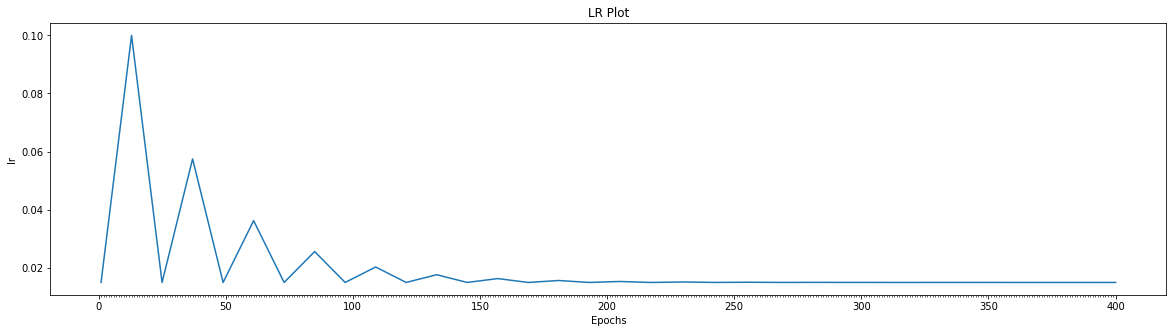

In [ ]:
m_history.plot_data_against_epoch(title="LR Plot", seriesname="lr", save_filename=f'{PLOT_DIR}/lr_plot.jpg')

In [ ]:
best_model = torch.load(f'{SAVED_MODELS_DIR}/bestmodel.pt')

In [ ]:
import utils.model_utils_ext as mutils_fxn
testacc, testsize = mutils_fxn.get_test_accuracy(best_model, device, test_loader)
print(f'Accuracy of the model on the {testsize} test images: {testacc:0.2f}%')

Accuracy of the model on the 1851 test images: 66.02%


In [ ]:
# Get Class based accuracy for custom classes
mutils_fxn.get_accuracy_for_specific_classes(best_model, device, test_loader, class_names, bws_class_names)

Accuracy of Akshay_Kumar : 87.50%
Accuracy of Amitabh_Bachchan : 12.50%
Accuracy of Amrish_Puri : 62.50%
Accuracy of Anil_Kapoor : 87.50%
Accuracy of Kajol : 50.00%
Accuracy of Katrina_Kaif : 75.00%
Accuracy of Madhuri_Dixit : 62.50%
Accuracy of Rajesh_Khanna : 62.50%
Accuracy of Shilpa_Shetty : 50.00%
Accuracy of Vinod_Khanna : 50.00%


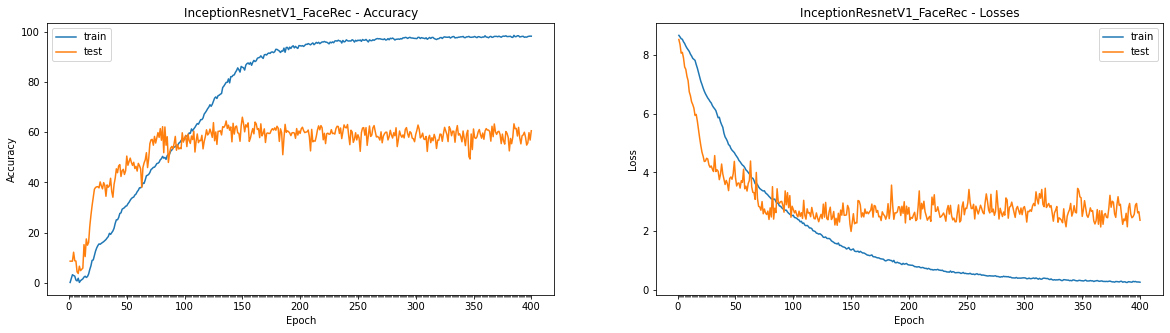

In [ ]:
# Accurracy and loss history plot
m_history.plot_history(title=model_name, save_filename=f'{PLOT_DIR}/model_history.jpg')